<a href="https://colab.research.google.com/github/jordlim/ecs171project/blob/main/occupancy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**ECS 171 Group Project**

Members:

- Jamie Wu
- Jordan Lim
- Rohan Arumugam
- Elson Jian
- Hyunkyong (HK) Boo
- Juntao Wang



In [110]:
# Imports - may or may not need all of these
!pip install xgboost imblearn
from xgboost import XGBClassifier
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, LabelBinarizer
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, mean_squared_error, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
from imblearn.over_sampling import RandomOverSampler
import warnings
warnings.filterwarnings('ignore') 

# Data Exploration

In [111]:
df = pd.read_csv("Occupancy_Estimation.csv")

# Check for duplicated values and drop them if necessary
df = df.drop_duplicates(subset = ['Date', 'Time'])

In [112]:
# Checks if there are any na values
df.isna().any()

Date                    False
Time                    False
S1_Temp                 False
S2_Temp                 False
S3_Temp                 False
S4_Temp                 False
S1_Light                False
S2_Light                False
S3_Light                False
S4_Light                False
S1_Sound                False
S2_Sound                False
S3_Sound                False
S4_Sound                False
S5_CO2                  False
S5_CO2_Slope            False
S6_PIR                  False
S7_PIR                  False
Room_Occupancy_Count    False
dtype: bool

In [113]:
df.describe() # overview of dataset

S1_Temp       S2_Temp       S3_Temp       S4_Temp      S1_Light  \
count  10129.000000  10129.000000  10129.000000  10129.000000  10129.000000   
mean      25.454012     25.546059     25.056621     25.754125     25.445059   
std        0.351351      0.586325      0.427283      0.356434     51.011264   
min       24.940000     24.750000     24.440000     24.940000      0.000000   
25%       25.190000     25.190000     24.690000     25.440000      0.000000   
50%       25.380000     25.380000     24.940000     25.750000      0.000000   
75%       25.630000     25.630000     25.380000     26.000000     12.000000   
max       26.380000     29.000000     26.190000     26.560000    165.000000   

          S2_Light      S3_Light      S4_Light      S1_Sound      S2_Sound  \
count  10129.00000  10129.000000  10129.000000  10129.000000  10129.000000   
mean      26.01629     34.248494     13.220259      0.168178      0.120066   
std       67.30417     58.400744     19.602219      0.316709      0.266503   
min        0.00000      0.000000      0.000000      0.060000      0.040000   
25%        0.00000      0.000000      0.000000      0.070000      0.050000   
50%        0.00000      0.000000      0.000000      0.080000      0.050000   
75%       14.00000     50.000000     22.000000      0.080000      0.060000   
max      258.00000    280.000000     74.000000      3.880000      3.440000   

           S3_Sound      S4_Sound        S5_CO2  S5_CO2_Slope        S6_PIR  \
count  10129.000000  10129.000000  10129.000000  10129.000000  10129.000000   
mean       0.158119      0.103840    460.860401     -0.004830      0.090137   
std        0.413637      0.120683    199.964940      1.164990      0.286392   
min        0.040000      0.050000    345.000000     -6.296154      0.000000   
25%        0.060000      0.060000    355.000000     -0.046154      0.000000   
50%        0.060000      0.080000    360.000000      0.000000      0.000000   
75%        0.070000      0.100000    465.000000      0.000000      0.000000   
max        3.670000      3.400000   1270.000000      8.980769      1.000000   

             S7_PIR  Room_Occupancy_Count  
count  10129.000000          10129.000000  
mean       0.079574              0.398559  
std        0.270645              0.893633  
min        0.000000              0.000000  
25%        0.000000              0.000000  
50%        0.000000              0.000000  
75%        0.000000              0.000000  
max        1.000000              3.000000

From df.isna(), we determine that there are no missing values.

From df.describe(), we see the ranges of our data as well as potential outliers.

- Temp: Consistenly around 25 / 26
- Light: Large outliers
- Sound: Relatively low data
- CO2: Large outliers
- PIR: Binary values, can use to confirm theories

In [114]:
for i in df:
    print(df[i].value_counts())

# gets value counts for each column in dataset
# This provides us information on the distribution

2017/12/23    2779
2017/12/25    1716
2017/12/22    1462
2017/12/24    1064
2017/12/26    1063
2018/01/11    1048
2018/01/10     997
Name: Date, dtype: int64
10:49:41    1
21:43:16    1
21:39:42    1
21:40:13    1
21:40:43    1
           ..
16:31:37    1
16:32:07    1
16:32:38    1
16:33:09    1
09:00:09    1
Name: Time, Length: 10129, dtype: int64
25.44    1132
25.19    1108
25.38    1024
25.06     995
25.13     980
25.31     860
25.25     703
25.50     293
25.94     292
26.25     268
26.19     268
25.56     246
25.81     244
26.06     232
25.88     231
25.69     226
25.63     207
26.00     193
26.13     173
25.75     165
26.31     143
25.00     125
26.38      19
24.94       2
Name: S1_Temp, dtype: int64
25.44    1389
25.13     964
25.38     947
25.06     939
25.19     896
         ... 
28.63       2
28.69       2
29.00       2
28.75       1
28.88       1
Name: S2_Temp, Length: 69, dtype: int64
24.56    812
24.63    745
24.69    651
24.94    620
24.81    611
24.88    572
25.06    570

In [115]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10129 entries, 0 to 10128
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Date                  10129 non-null  object 
 1   Time                  10129 non-null  object 
 2   S1_Temp               10129 non-null  float64
 3   S2_Temp               10129 non-null  float64
 4   S3_Temp               10129 non-null  float64
 5   S4_Temp               10129 non-null  float64
 6   S1_Light              10129 non-null  int64  
 7   S2_Light              10129 non-null  int64  
 8   S3_Light              10129 non-null  int64  
 9   S4_Light              10129 non-null  int64  
 10  S1_Sound              10129 non-null  float64
 11  S2_Sound              10129 non-null  float64
 12  S3_Sound              10129 non-null  float64
 13  S4_Sound              10129 non-null  float64
 14  S5_CO2                10129 non-null  int64  
 15  S5_CO2_Slope       

<AxesSubplot: >

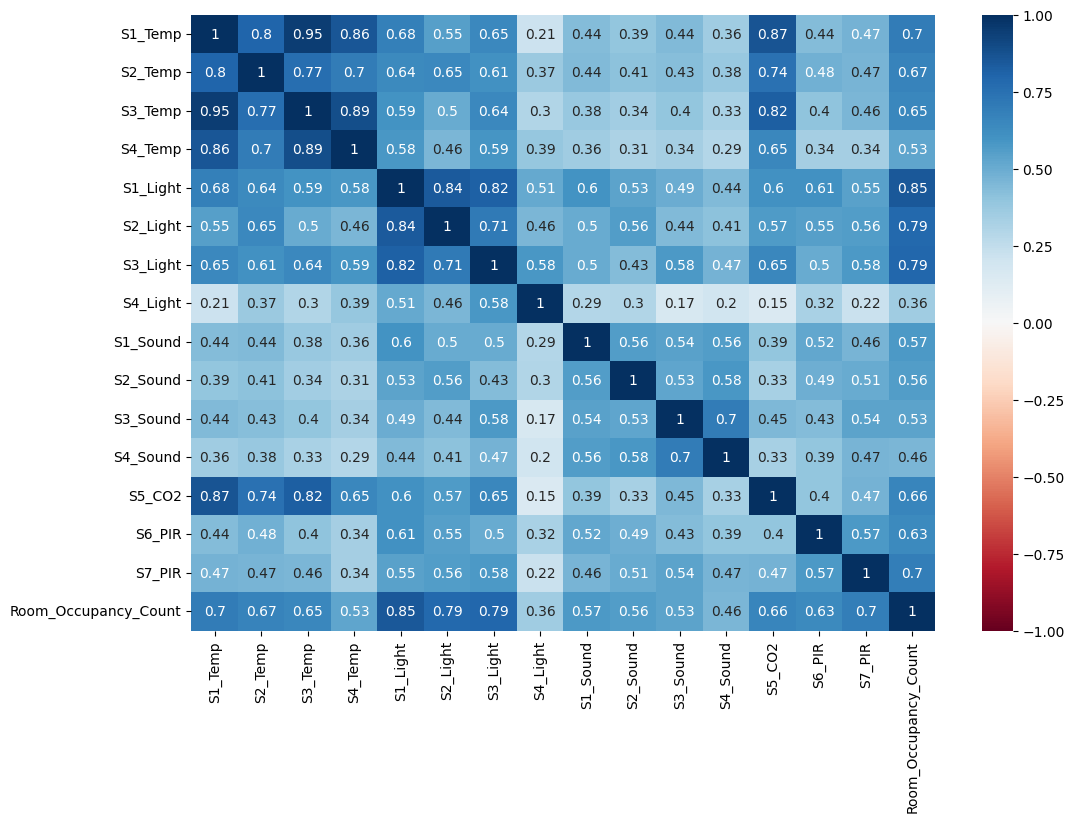

In [116]:
# In the data exploration and preprocessing step, we will work with df_v1 which is a copy of the original df
# Remove categorical / unclear data
# Date/Time is incorporated into Pandas DateTime, and CO2_Slope we recreate with delta CO2 in a separate dataframe
df_v1 = df.drop(columns=['Date', 'Time', 'S5_CO2_Slope'])
corr = df_v1.corr()

# Increase size of plot to fit all the values
plt.figure(figsize=(12, 8))
sns.heatmap(corr, vmin=-1, vmax=1, center=0, annot=True, cmap= 'RdBu')
# All positively correlated

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10129 entries, 0 to 10128
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   S1_Temp               10129 non-null  float64
 1   S2_Temp               10129 non-null  float64
 2   S3_Temp               10129 non-null  float64
 3   S4_Temp               10129 non-null  float64
 4   S1_Light              10129 non-null  int64  
 5   S2_Light              10129 non-null  int64  
 6   S3_Light              10129 non-null  int64  
 7   S4_Light              10129 non-null  int64  
 8   S1_Sound              10129 non-null  float64
 9   S2_Sound              10129 non-null  float64
 10  S3_Sound              10129 non-null  float64
 11  S4_Sound              10129 non-null  float64
 12  S5_CO2                10129 non-null  int64  
 13  S6_PIR                10129 non-null  int64  
 14  S7_PIR                10129 non-null  int64  
 15  Room_Occupancy_Coun

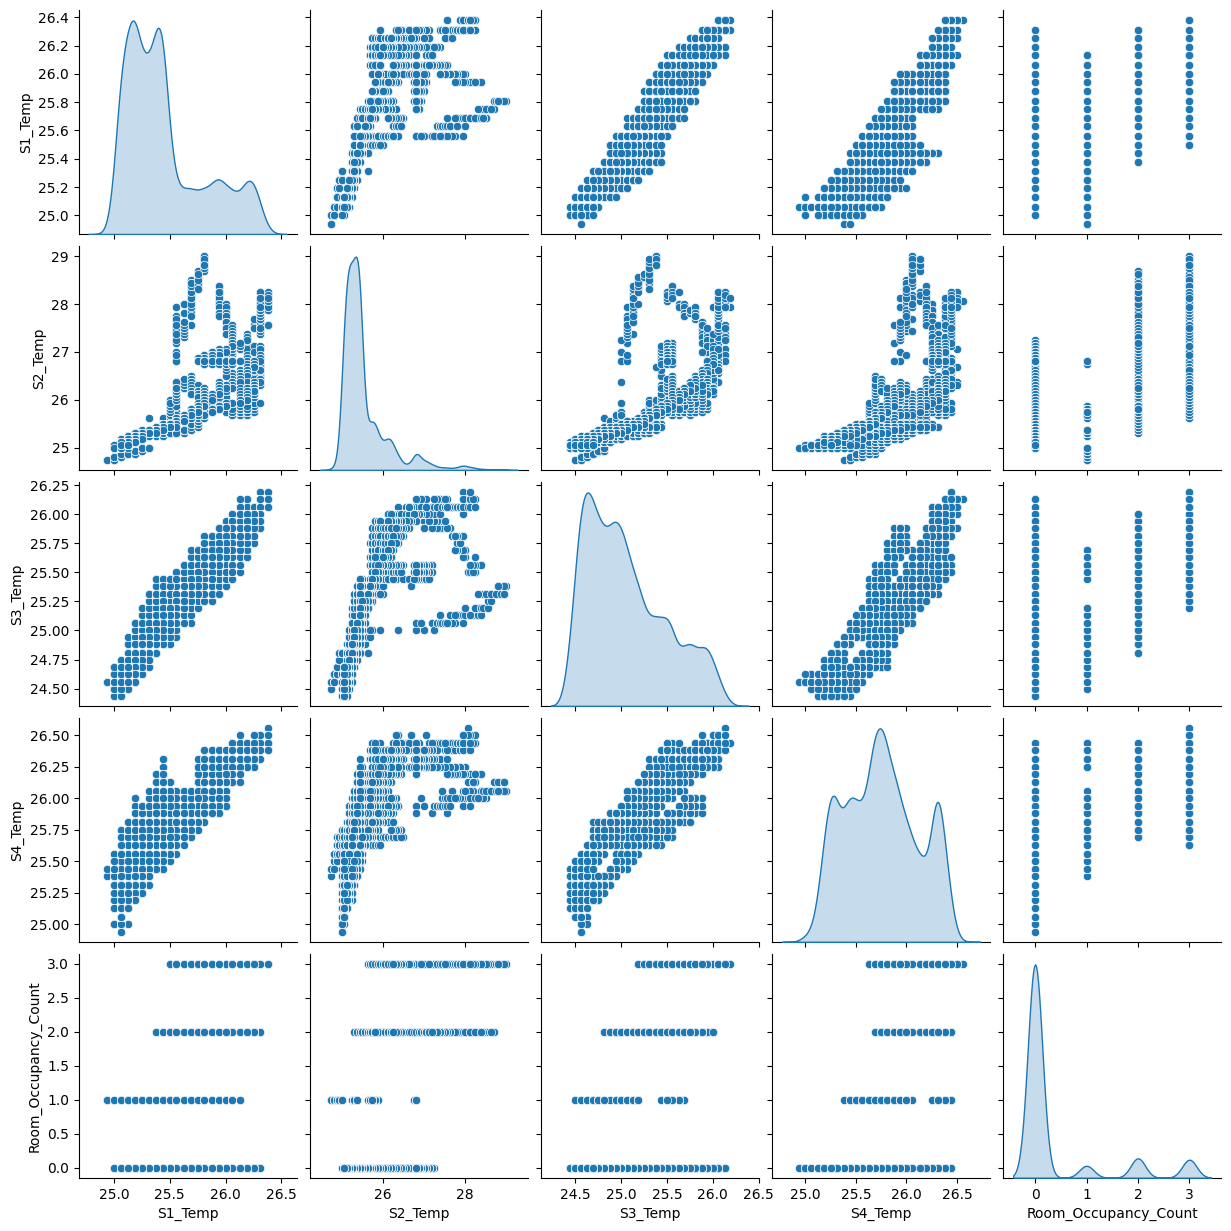

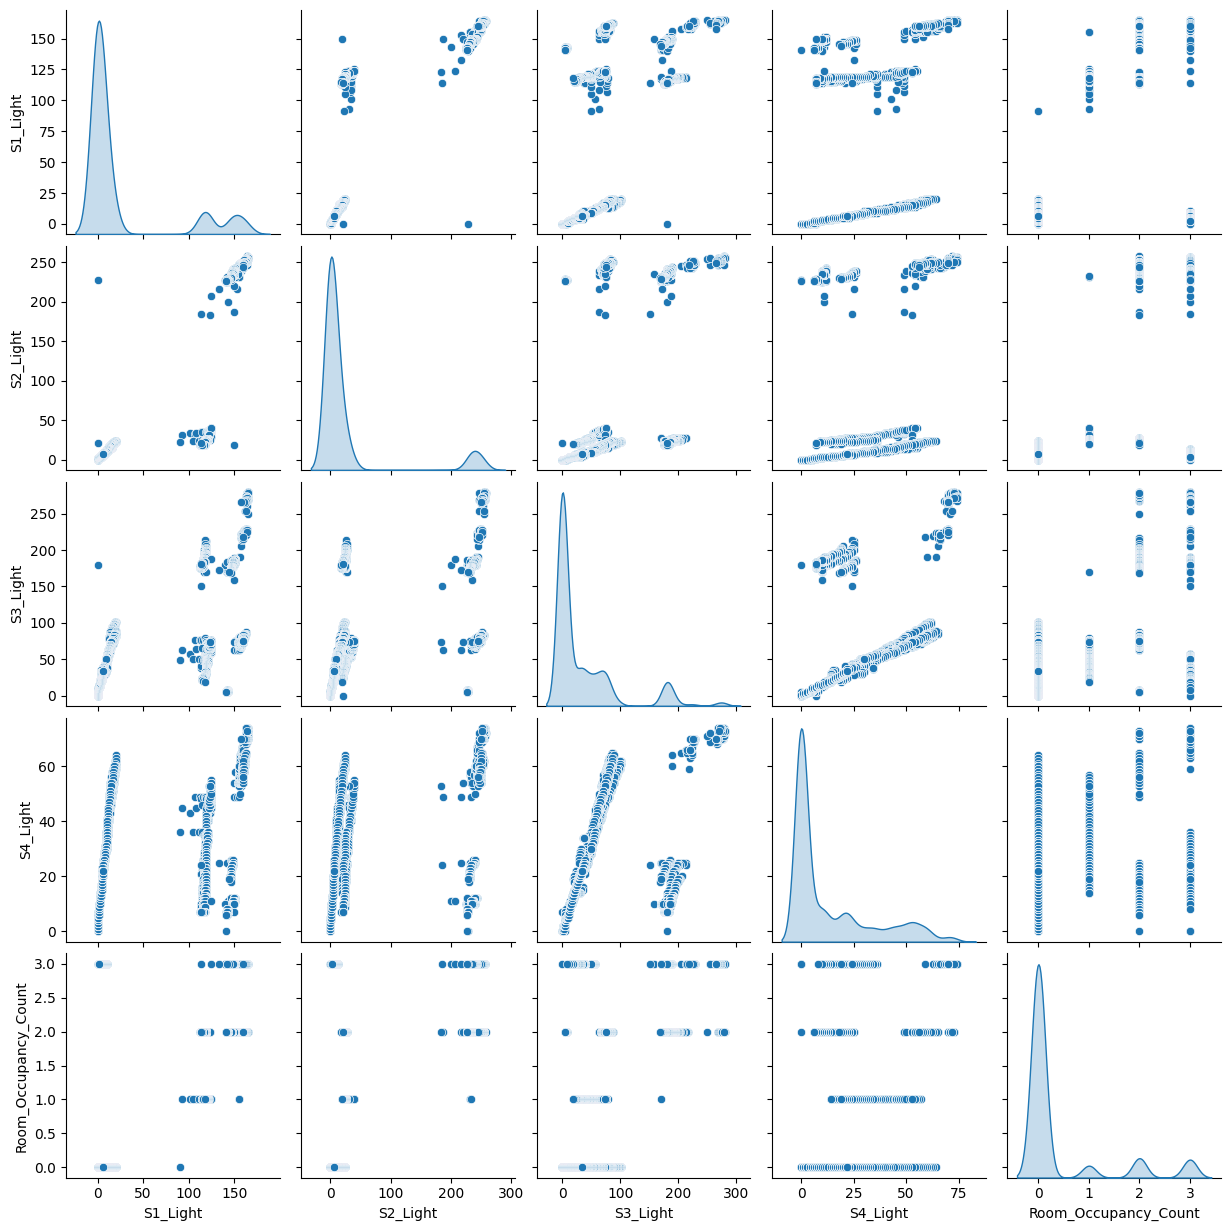

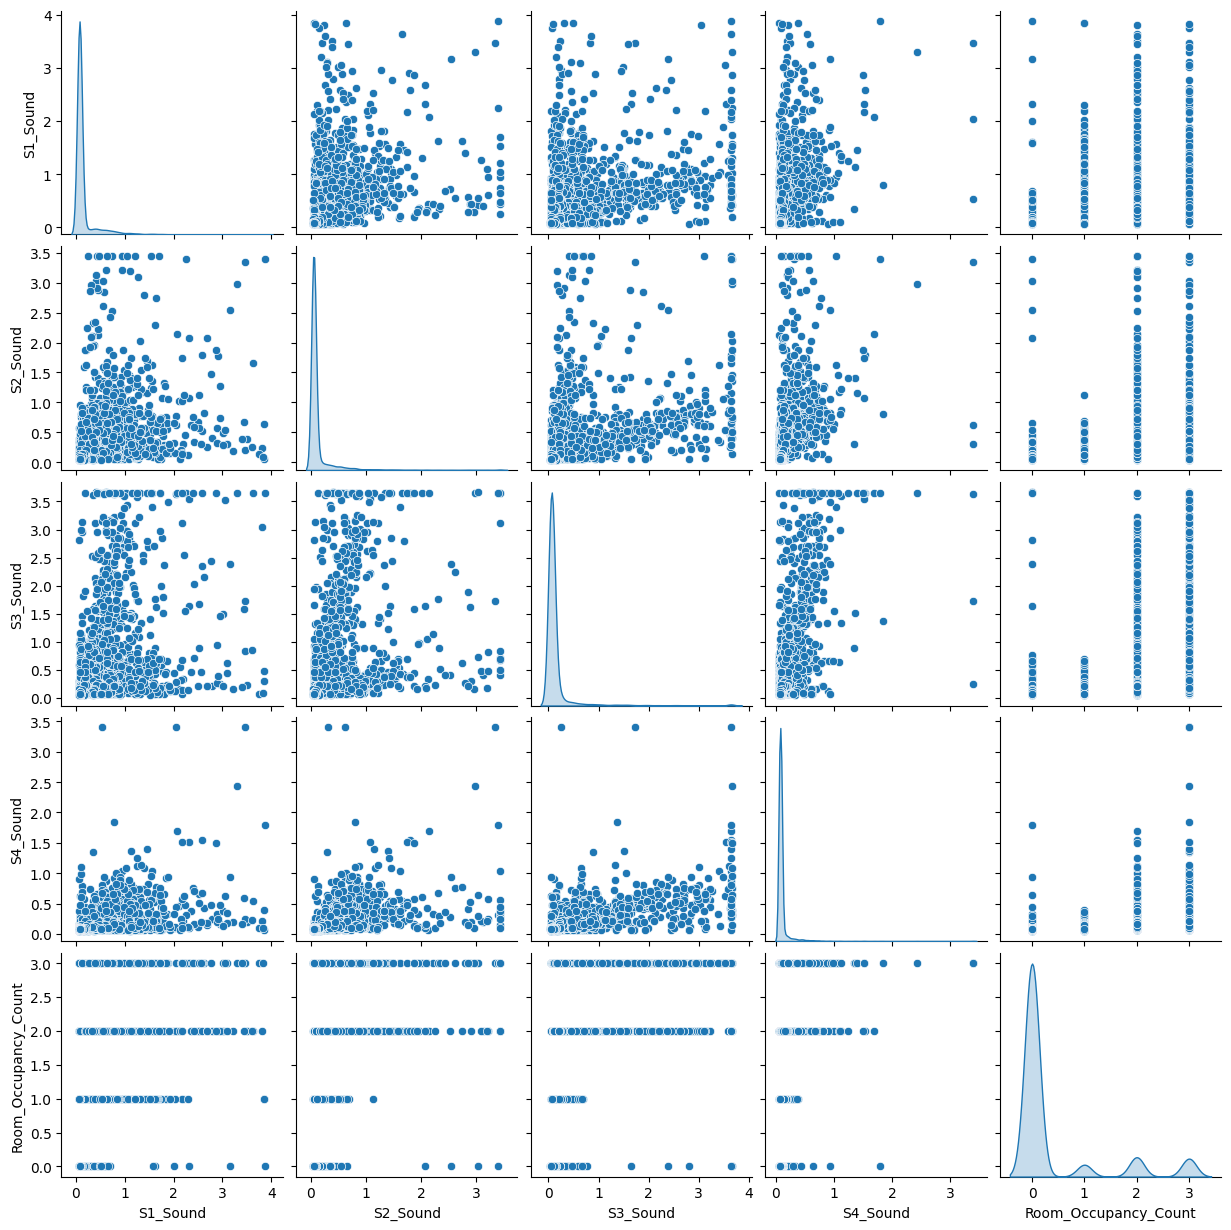

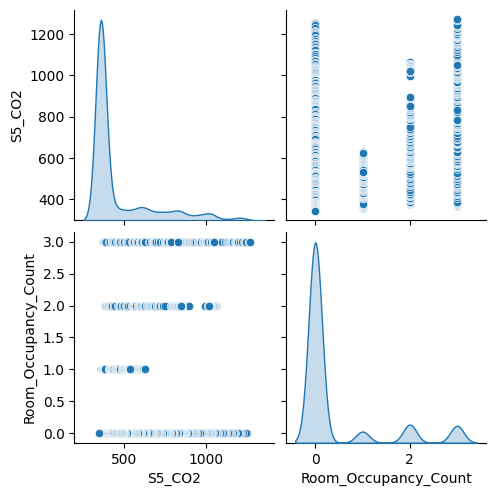

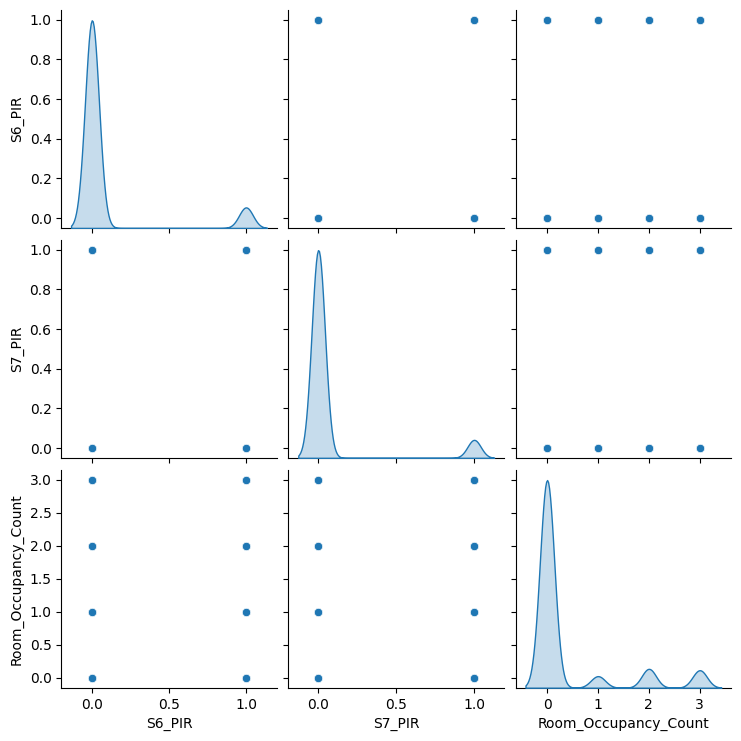

In [117]:
# Splitting the data into different types along with Room_Occupancy_Count (index 16)
df_v1.info()
df_temp = df_v1.iloc[:, [0, 1, 2, 3, 15]]
df_light = df_v1.iloc[:, [4, 5, 6, 7, 15]]
df_sound = df_v1.iloc[:, [8, 9, 10, 11, 15]]
df_co2 = df_v1.iloc[:, [12, 15]]
df_pir = df_v1.iloc[:, [13, 14, 15]]

# Scatterplots of our different data types grouped into 4 categories

# Temperature Scatter
sns.pairplot(df_temp, diag_kind='kde')
# Won't need transformation


# Light Scatter
sns.pairplot(df_light, diag_kind='kde')


# Sound Scatter
sns.pairplot(df_sound, diag_kind='kde')
# Data is slightly skewed and may benefit from a log transformation


# CO2 Scatter
sns.pairplot(df_co2, diag_kind='kde')

# PIR Scatter
sns.pairplot(df_pir, diag_kind='kde')


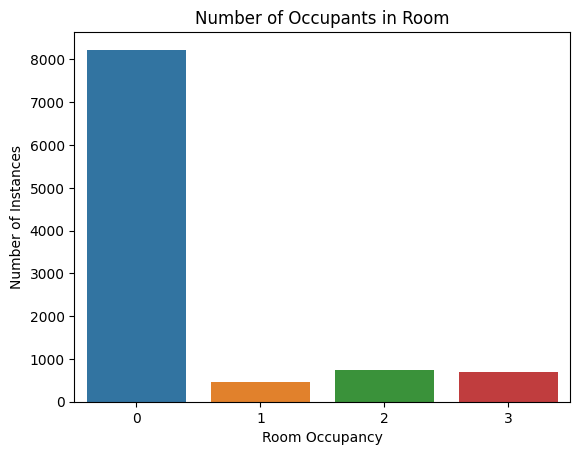

In [118]:
# Room occupancy count
unq_occupants = df['Room_Occupancy_Count'].value_counts().sort_index()
sns.barplot(x = unq_occupants.index, y = unq_occupants.values)
plt.ylabel('Number of Instances')
plt.xlabel('Room Occupancy')
plt.title('Number of Occupants in Room')
plt.show()

# Proportion of observations that had people inside the room during the measurement
occupants_proportion = (unq_occupants / (unq_occupants.sum())) * 100



# Data Preprocessing

In [119]:
# Now that we have explored the data and decided what preprocessing we might want to do (see README.md)
# We will resume using the original dataframe df instead of the copy df_v1 to do the preprocessing
# Convert time to datetime for easier plotting

df['DateTime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])

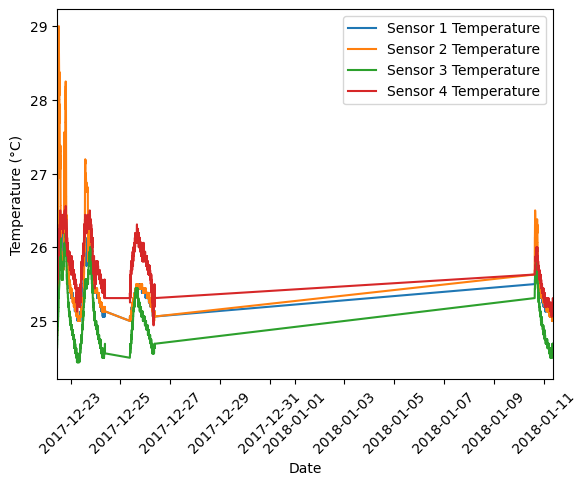

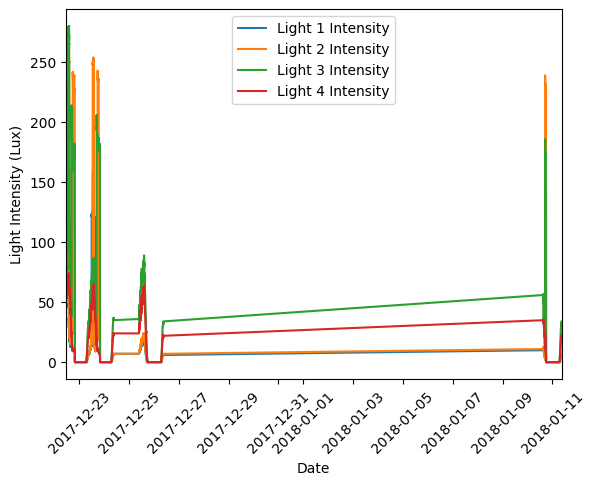

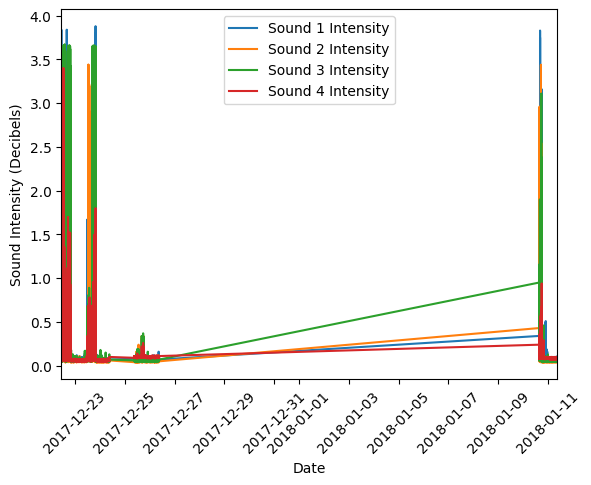

In [120]:
# Sensors S1-S4
# Temperature against DateTime
plt.plot(df['DateTime'], df['S1_Temp'])
plt.plot(df['DateTime'], df['S2_Temp'])
plt.plot(df['DateTime'], df['S3_Temp'])
plt.plot(df['DateTime'], df['S4_Temp'])
plt.legend(['Sensor 1 Temperature', 'Sensor 2 Temperature', 'Sensor 3 Temperature', 'Sensor 4 Temperature'])

plt.ylabel('Temperature (\u00b0C)')
plt.xlabel('Date')
plt.xlim(df['DateTime'].min(), df['DateTime'].max())
plt.xticks(rotation = 45)
plt.show()

# Light against DateTime
plt.plot(df['DateTime'], df['S1_Light'])
plt.plot(df['DateTime'], df['S2_Light'])
plt.plot(df['DateTime'], df['S3_Light'])
plt.plot(df['DateTime'], df['S4_Light'])
plt.legend(['Light 1 Intensity', 'Light 2 Intensity', 'Light 3 Intensity', 'Light 4 Intensity'])

plt.ylabel('Light Intensity (Lux)')
plt.xlabel('Date')
plt.xlim(df['DateTime'].min(), df['DateTime'].max())
plt.xticks(rotation = 45)
plt.show()

# Sound against DateTime
plt.plot(df['DateTime'], df['S1_Sound'])
plt.plot(df['DateTime'], df['S2_Sound'])
plt.plot(df['DateTime'], df['S3_Sound'])
plt.plot(df['DateTime'], df['S4_Sound'])
plt.legend(['Sound 1 Intensity', 'Sound 2 Intensity', 'Sound 3 Intensity', 'Sound 4 Intensity'])

plt.ylabel('Sound Intensity (Decibels)')
plt.xlabel('Date')
plt.xlim(df['DateTime'].min(), df['DateTime'].max())
plt.xticks(rotation = 45)
plt.show()

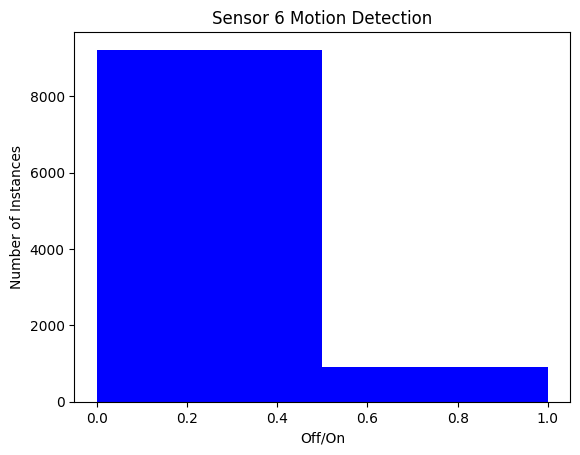

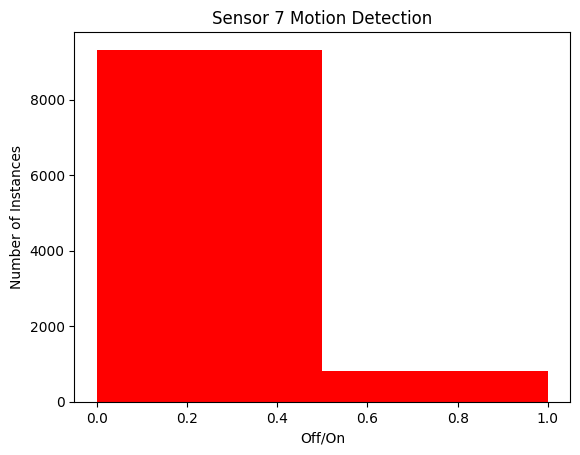

In [121]:
# Sensor 6 Motion Detection
plt.hist(df['S6_PIR'], bins = 2, color = 'blue')
plt.ylabel('Number of Instances')
plt.xlabel('Off/On')
plt.title('Sensor 6 Motion Detection')
s6_pir_percentage = (df['S6_PIR'] / (df['S6_PIR'].sum())) * 100
plt.show()

# Sensor 7 Motion Detection
plt.hist(df['S7_PIR'], bins = 2, color = 'red')
plt.ylabel('Number of Instances')
plt.xlabel('Off/On')
plt.title('Sensor 7 Motion Detection')
s7_pir_percentage = (df['S7_PIR'] / (df['S7_PIR'].sum())) * 100
plt.show()

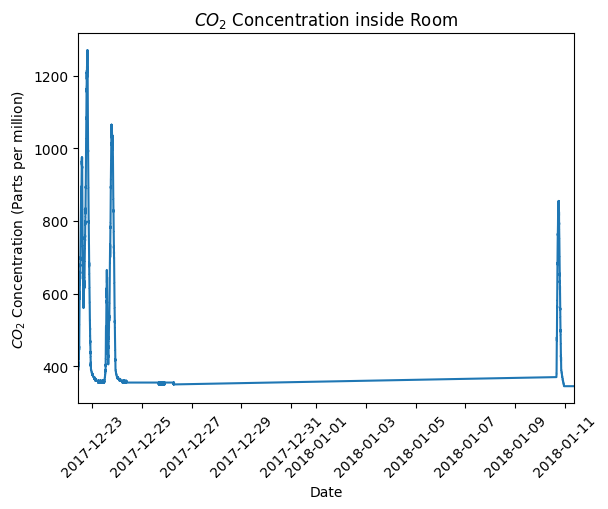

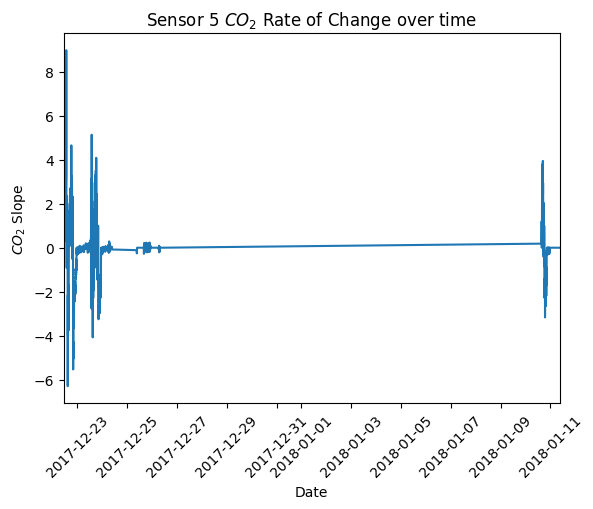

In [122]:
# CO2 Concentration Sensor
plt.plot(df['DateTime'], df['S5_CO2'])
plt.xlim(df['DateTime'].min(), df['DateTime'].max())
plt.xticks(rotation = 45)
plt.xlabel('Date')
plt.ylabel('$CO_{2}$ Concentration (Parts per million)')
plt.title('$CO_{2}$ Concentration inside Room')
plt.show()

# CO2 Slope
plt.plot(df['DateTime'], df['S5_CO2_Slope'])
plt.xlim(df['DateTime'].min(), df['DateTime'].max())
plt.xticks(rotation = 45)
plt.xlabel('Date')
plt.ylabel('$CO_{2}$ Slope')
plt.title('Sensor 5 $CO_{2}$ Rate of Change over time')
plt.show()

In [123]:
y_os

0        1
1        1
2        1
3        1
4        1
        ..
10124    0
10125    0
10126    0
10127    0
10128    0
Name: Room_Occupancy_Count, Length: 10129, dtype: int64

In [124]:
# Moving on to scaling -> dropping date and time before scaling numerical sensor output
dates = df['DateTime']
df = df.drop(columns = ['Date', 'Time', 'DateTime'])

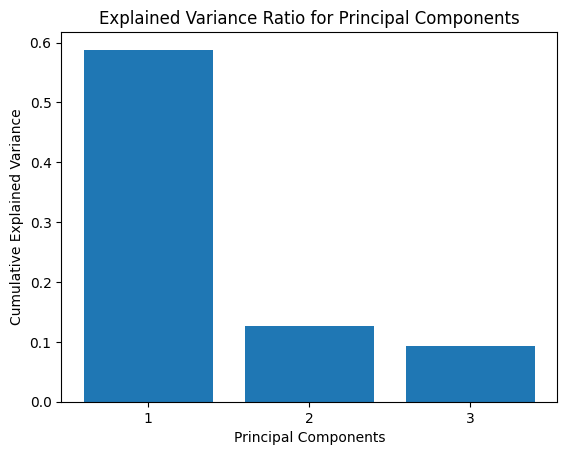

In [125]:
# Finishing up preprocessing of the data by standardizing inputs and encoding outputs
scaler = MinMaxScaler()
encoder = LabelBinarizer() # input categorical data and output numpy array

X = df.iloc[:, :-1] # get all columns except room_occupancy
y = df.iloc[:,-1] # room occupancy

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 2)
y_encoded = tf.keras.utils.to_categorical(y, num_classes = 4)
y_train_encoded = tf.keras.utils.to_categorical(y_train, num_classes = 4) # convert to categorical data for later analysis
y_test_encoded = tf.keras.utils.to_categorical(y_test, num_classes = 4) # convert to categorical data for later analysis

x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)
X_scaled_og = scaler.transform(X)

pca = PCA(n_components = 3) # reduce number of features in dataset from 17 to 3 with pca
reduced_x = pca.fit_transform(X_scaled_og)

reduced_x_train = pca.fit_transform(x_train_scaled)
reduced_x_test = pca.transform(x_test_scaled)

plt.bar(range(3), pca.explained_variance_ratio_)
plt.xticks(range(3), range(1,4)) # set x ticks to be equal to first 3 principal components
plt.xlabel('Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance Ratio for Principal Components')
plt.show()

In [126]:
X_os = df.iloc[:, :-1] # get all columns except room_occupancy
y_os = df.iloc[:,-1] # room occupancy

ros = RandomOverSampler(random_state=9)
X_resampled, y_resampled = ros.fit_resample(X_os,y_os)

x_train_os, x_test_os, y_train_os, y_test_os = train_test_split(X_resampled, y_resampled, test_size = 0.2, random_state = 2)

y_train_encoded_os = tf.keras.utils.to_categorical(y_train_os, num_classes = 4) # convert to categorical data for later analysis
y_test_encoded_os = tf.keras.utils.to_categorical(y_test_os, num_classes = 4) # convert to categorical data for later analysis
y_encoded_os = tf.keras.utils.to_categorical(y_os, num_classes=4)

x_train_scaled_os = scaler.fit_transform(x_train_os)
x_test_scaled_os = scaler.transform(x_test_os)
X_scaled_os = scaler.fit_transform(X_os)

# Data Modeling

In [127]:
models = {'Artificial Neural Network': Sequential(),
'Logistic Regression': LogisticRegression(),
'Decision Tree': DecisionTreeClassifier(),
'K-Nearest Neighbors': KNeighborsClassifier(),
'Support Vector Machine': SVC(),
'Random Forest': RandomForestClassifier(),
'Gradient Boosting': XGBClassifier(),
'Naive Bayes': GaussianNB()} # dictionary of models to iterate data through

mse_ann = [] # list to hold mse values for ann cross 10fold cross validation
accuracy_ann = [] 


def model_building(x_train_scaled, y_train, x_test_scaled, y_test, y_train_encoded, y_test_encoded, models:dict, res:list, dim:int, cross_val = True, os = False):
    """This function should help with creating models for different variations of our dataset. The dim input lets us
    switch the number of input dimensions. """
    # it looks like i need to do cross validation for the ann here :/        
    for name, model in models.items(): # iterate through model dictionary for fittting
        if name == 'Artificial Neural Network':
            # run ann if its selected from model list
            model.add(Dense(units = 12, activation = 'sigmoid', input_dim = dim)) # input layer
            model.add(Dense(units = 3, activation = 'sigmoid'))
            model.add(Dense(units = 4, activation = 'softmax')) # output layer

            adjusted_sgd = SGD(learning_rate= 0.2) # set learning rate for gradient descent
            model.compile(optimizer= adjusted_sgd, loss = 'categorical_crossentropy')
            model.fit(x_train_scaled, y_train_encoded, epochs = 50)

            pred_train = model.predict(x_train_scaled)
            pred_test = model.predict(x_test_scaled) # store predictions that can be evaluated later in loop
            y_labels_train = np.argmax(pred_train, axis = 1)
            y_labels_test = np.argmax(pred_test, axis = 1)
            y_true_train = np.argmax(y_train_encoded, axis = 1)
            y_true_test = np.argmax(y_test_encoded, axis = 1)

            confused_mat_train = confusion_matrix(y_true_train, y_labels_train)
            class_rep_train = classification_report(y_true_train, y_labels_train)
            accuracy_rate_train = accuracy_score(y_true_train, y_labels_train)
            train_mse_score = mean_squared_error(y_true_train, y_labels_train)

            confused_mat_test = confusion_matrix(y_true_test, y_labels_test)
            class_rep_test = classification_report(y_true_test, y_labels_test)
            accuracy_rate_test = accuracy_score(y_true_test, y_labels_test)
            test_mse_score = mean_squared_error(y_true_test, y_labels_test)

            res.append((confused_mat_train, confused_mat_test, class_rep_train, class_rep_test, accuracy_rate_train, accuracy_rate_test, train_mse_score, test_mse_score))
            matrix_on_display_train = ConfusionMatrixDisplay(confused_mat_train).plot() # plot confusion matrix
            plt.title(f'Confusion Matrix for {name} training set')
            plt.show()

            matrix_on_display_test = ConfusionMatrixDisplay(confused_mat_test).plot() # plot confusion matrix
            plt.title(f'Confusion Matrix for {name} testing set')
            plt.show()

            print(f'Classification report for {name} training set:\n {class_rep_train}')
            print(f'Classification report for {name} testing set:\n {class_rep_test}')
            print(f'Accuracy Score for {name} training set: {accuracy_rate_train}\n')
            print(f'Accuracy Score for {name} testing set: {accuracy_rate_test}\n')
            print(f'Mean Squared Error for {name} training set: {train_mse_score}\n')
            print(f'Mean Squared Error for {name} testing set: {test_mse_score}\n')

            if cross_val == True and dim == 16 and os == False: # do kfold cross validation if true 
                kf = StratifiedKFold(n_splits = 10)
                for train_index, test_index in kf.split(x_train_scaled, y_train):
                    xfold_train, xfold_test = X_scaled_og[train_index], X_scaled_og[test_index]
                    yfold_train, yfold_test = y_encoded[train_index], y_encoded[test_index]

                    model.fit(xfold_train, yfold_train, batch_size = 1, epochs = 10)

                    y_ann_pred = model.predict(xfold_test)

                    #ann_accuracy = accuracy_score(yfold_test, y_ann_pred)
                    ann_mse = mean_squared_error(yfold_test, y_ann_pred)
                    mse_ann.append(ann_mse)
                    #accuracy_ann.append(ann_accuracy)
            elif cross_val == True and dim == 3:
                # pca dataset needs some tweaks before cross validating
                kf = StratifiedKFold(n_splits = 10)
                for train_index, test_index in kf.split(reduced_x_train, y_train):
                    xfold_train, xfold_test = reduced_x[train_index], reduced_x[test_index]
                    yfold_train, yfold_test = y_encoded[train_index], y_encoded[test_index]

                    model.fit(xfold_train, yfold_train, batch_size = 1, epochs = 10)

                    y_ann_pred = model.predict(xfold_test)

                    #ann_accuracy = accuracy_score(yfold_test, y_ann_pred)
                    ann_mse = mean_squared_error(yfold_test, y_ann_pred)
                    mse_ann.append(ann_mse)
                    #accuracy_ann.append(ann_accuracy)
            elif cross_val == True and os == True:
                # oversampled dataset
                kf = StratifiedKFold(n_splits = 10)
                for train_index, test_index in kf.split(x_train_scaled_os - 1, y_train_os - 1):
                    print("Train Index:", train_index)
                    print("Test Index:", test_index)
                    
                    xfold_train, xfold_test = X_scaled_os[train_index - 1], X_scaled_os[test_index - 1]
                    yfold_train, yfold_test = y_encoded_os[train_index - 1], y_encoded_os[test_index - 1]

                    model.fit(xfold_train, yfold_train, batch_size = 1, epochs = 10)

                    y_ann_pred = model.predict(xfold_test)

                    #ann_accuracy = accuracy_score(yfold_test, y_ann_pred)
                    ann_mse = mean_squared_error(yfold_test, y_ann_pred)
                    mse_ann.append(ann_mse)
                    #accuracy_ann.append(ann_accuracy)

                    
        else:
            model.fit(x_train_scaled, y_train)
            pred_train = model.predict(x_train_scaled)
            pred_test = model.predict(x_test_scaled) # store predictions that can be evaluated later in loop

            confused_mat_train = confusion_matrix(y_train, pred_train) # create metrics to analyze later
            class_rep_train = classification_report(y_train, pred_train)
            accuracy_rate_train = accuracy_score(y_train, pred_train)
            train_mse_score = mean_squared_error(y_train, pred_train)

            confused_mat_test = confusion_matrix(y_test, pred_test)
            class_rep_test = classification_report(y_test, pred_test)
            accuracy_rate_test = accuracy_score(y_test, pred_test)
            test_mse_score = mean_squared_error(y_test, pred_test)

            matrix_on_display_train = ConfusionMatrixDisplay(confused_mat_train).plot() # plot confusion matrix
            plt.title(f'Confusion Matrix for {name} training set')
            plt.show()

            matrix_on_display_test = ConfusionMatrixDisplay(confused_mat_test).plot() # plot confusion matrix
            plt.title(f'Confusion Matrix for {name} testing set')
            plt.show()

            print(f'Classification report for {name} training set:\n {class_rep_train}')
            print(f'Classification report for {name} testing set:\n {class_rep_test}')
            print(f'Accuracy Score for {name} training set: {accuracy_rate_train}\n')
            print(f'Accuracy Score for {name} testing set: {accuracy_rate_test}\n')
            print(f'Mean Squared Error for {name} training set: {train_mse_score}\n')
            print(f'Mean Squared Error for {name} testing set: {test_mse_score}\n')

            res.append((confused_mat_train, confused_mat_test, class_rep_train, class_rep_test, accuracy_rate_train, accuracy_rate_test, train_mse_score, test_mse_score))





Epoch 1/50
254/254 [==============================] - 1s 1ms/step - loss: 0.6834
Epoch 2/50
254/254 [==============================] - 0s 1ms/step - loss: 0.5706
Epoch 3/50
254/254 [==============================] - 0s 1ms/step - loss: 0.3595
Epoch 4/50
254/254 [==============================] - 0s 1ms/step - loss: 0.2772
Epoch 5/50
254/254 [==============================] - 0s 1ms/step - loss: 0.2525
Epoch 6/50
254/254 [==============================] - 0s 1ms/step - loss: 0.2416
Epoch 7/50
254/254 [==============================] - 0s 1ms/step - loss: 0.2354
Epoch 8/50
254/254 [==============================] - 0s 1ms/step - loss: 0.2318
Epoch 9/50
254/254 [==============================] - 0s 1ms/step - loss: 0.2288
Epoch 10/50
254/254 [==============================] - 0s 1ms/step - loss: 0.2267
Epoch 11/50
254/254 [==============================] - 0s 1ms/step - loss: 0.2247
Epoch 12/50
254/254 [==============================] - 0s 1ms/step - loss: 0.2227
Epoch 13/50
254/254 [====

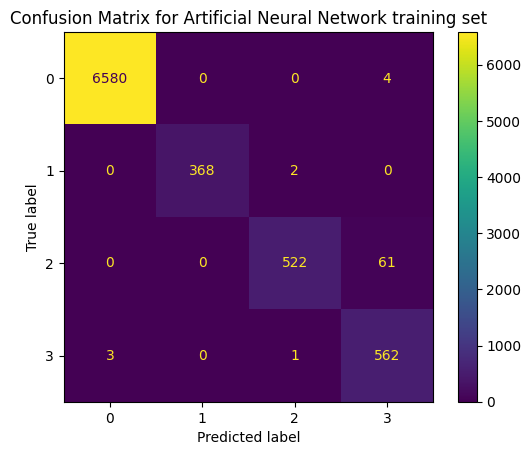

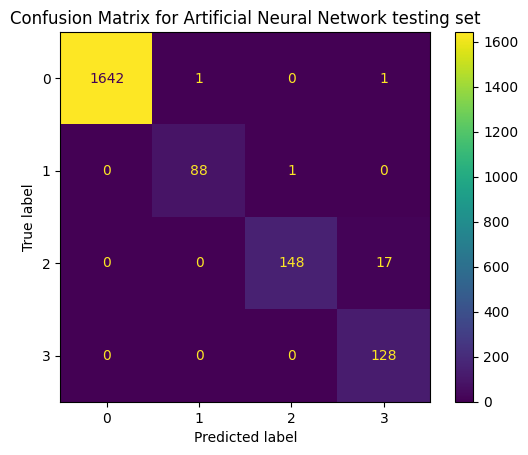

Classification report for Artificial Neural Network training set:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      6584
           1       1.00      0.99      1.00       370
           2       0.99      0.90      0.94       583
           3       0.90      0.99      0.94       566

    accuracy                           0.99      8103
   macro avg       0.97      0.97      0.97      8103
weighted avg       0.99      0.99      0.99      8103

Classification report for Artificial Neural Network testing set:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1644
           1       0.99      0.99      0.99        89
           2       0.99      0.90      0.94       165
           3       0.88      1.00      0.93       128

    accuracy                           0.99      2026
   macro avg       0.96      0.97      0.97      2026
weighted avg       0.99      0.99      0.99      202

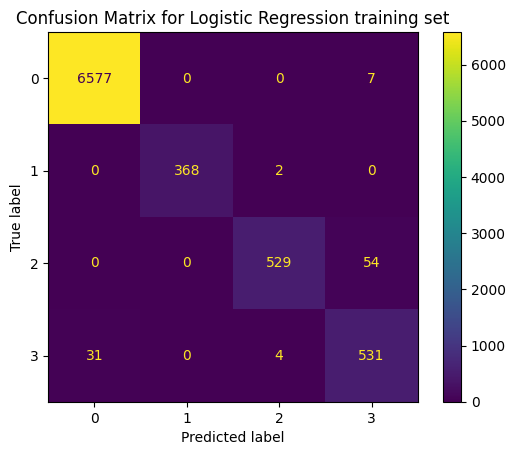

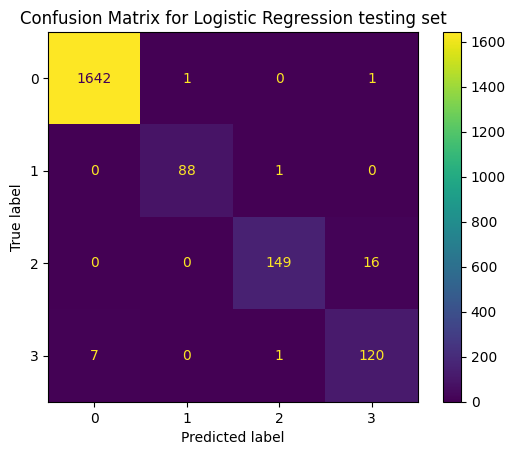

Classification report for Logistic Regression training set:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      6584
           1       1.00      0.99      1.00       370
           2       0.99      0.91      0.95       583
           3       0.90      0.94      0.92       566

    accuracy                           0.99      8103
   macro avg       0.97      0.96      0.96      8103
weighted avg       0.99      0.99      0.99      8103

Classification report for Logistic Regression testing set:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1644
           1       0.99      0.99      0.99        89
           2       0.99      0.90      0.94       165
           3       0.88      0.94      0.91       128

    accuracy                           0.99      2026
   macro avg       0.96      0.96      0.96      2026
weighted avg       0.99      0.99      0.99      2026

Accuracy 

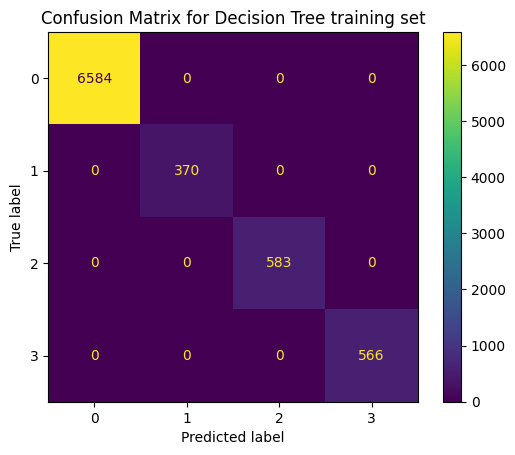

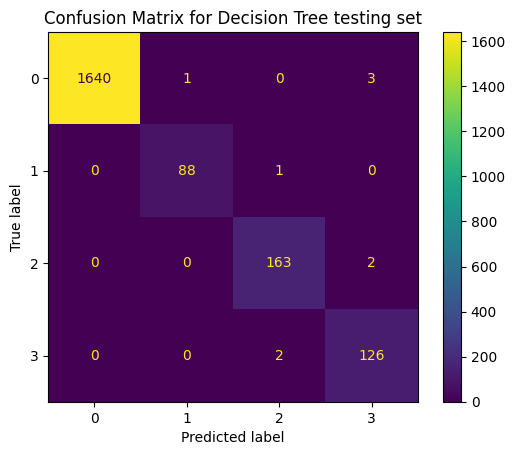

Classification report for Decision Tree training set:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      6584
           1       1.00      1.00      1.00       370
           2       1.00      1.00      1.00       583
           3       1.00      1.00      1.00       566

    accuracy                           1.00      8103
   macro avg       1.00      1.00      1.00      8103
weighted avg       1.00      1.00      1.00      8103

Classification report for Decision Tree testing set:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1644
           1       0.99      0.99      0.99        89
           2       0.98      0.99      0.98       165
           3       0.96      0.98      0.97       128

    accuracy                           1.00      2026
   macro avg       0.98      0.99      0.99      2026
weighted avg       1.00      1.00      1.00      2026

Accuracy Score for De

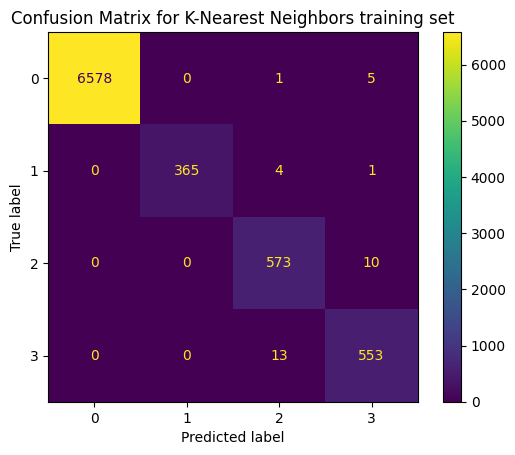

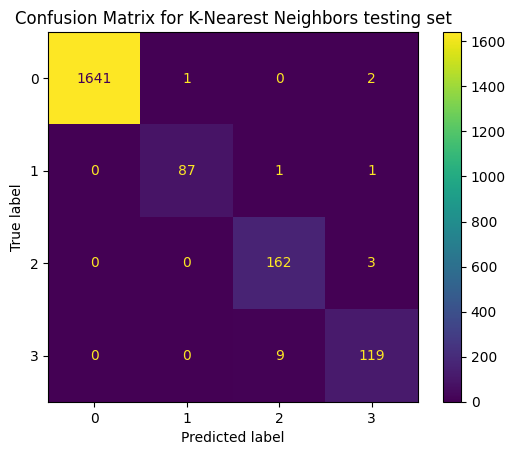

Classification report for K-Nearest Neighbors training set:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      6584
           1       1.00      0.99      0.99       370
           2       0.97      0.98      0.98       583
           3       0.97      0.98      0.97       566

    accuracy                           1.00      8103
   macro avg       0.99      0.99      0.99      8103
weighted avg       1.00      1.00      1.00      8103

Classification report for K-Nearest Neighbors testing set:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1644
           1       0.99      0.98      0.98        89
           2       0.94      0.98      0.96       165
           3       0.95      0.93      0.94       128

    accuracy                           0.99      2026
   macro avg       0.97      0.97      0.97      2026
weighted avg       0.99      0.99      0.99      2026

Accuracy 

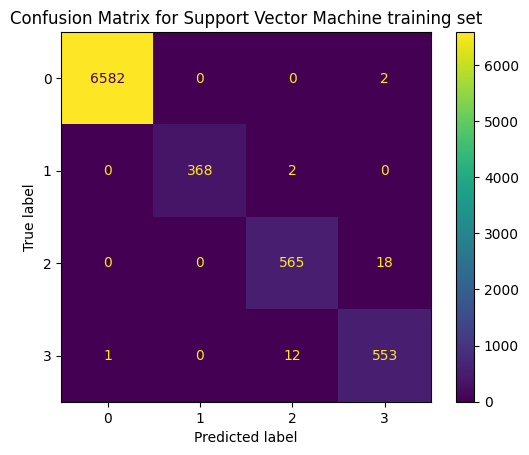

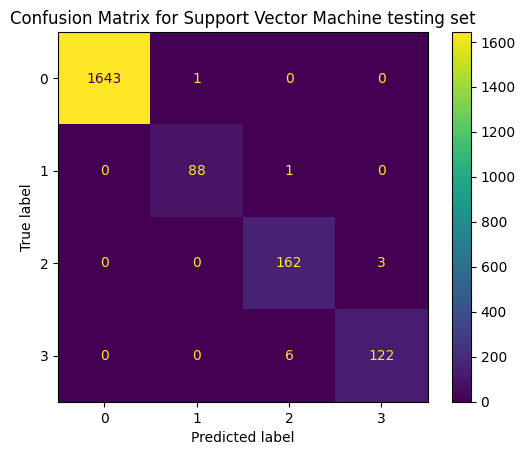

Classification report for Support Vector Machine training set:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      6584
           1       1.00      0.99      1.00       370
           2       0.98      0.97      0.97       583
           3       0.97      0.98      0.97       566

    accuracy                           1.00      8103
   macro avg       0.99      0.99      0.99      8103
weighted avg       1.00      1.00      1.00      8103

Classification report for Support Vector Machine testing set:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1644
           1       0.99      0.99      0.99        89
           2       0.96      0.98      0.97       165
           3       0.98      0.95      0.96       128

    accuracy                           0.99      2026
   macro avg       0.98      0.98      0.98      2026
weighted avg       0.99      0.99      0.99      2026

Acc

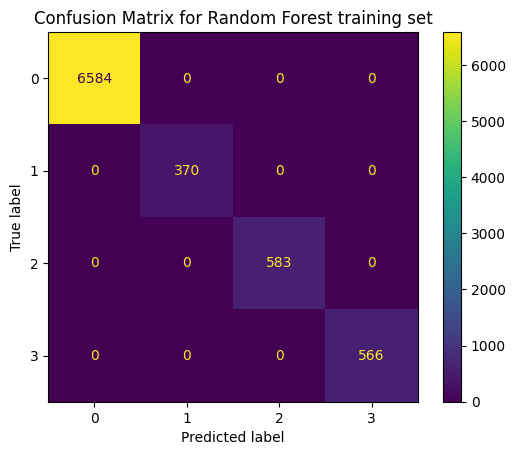

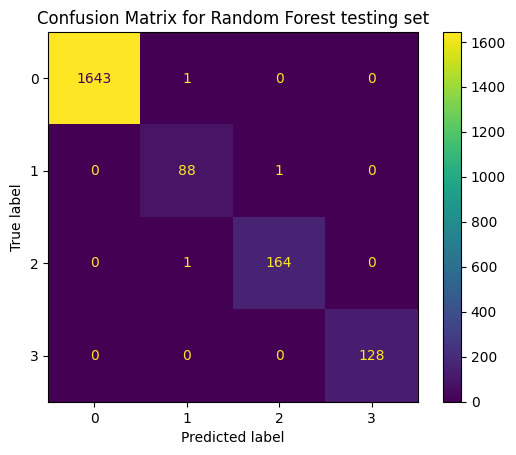

Classification report for Random Forest training set:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      6584
           1       1.00      1.00      1.00       370
           2       1.00      1.00      1.00       583
           3       1.00      1.00      1.00       566

    accuracy                           1.00      8103
   macro avg       1.00      1.00      1.00      8103
weighted avg       1.00      1.00      1.00      8103

Classification report for Random Forest testing set:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1644
           1       0.98      0.99      0.98        89
           2       0.99      0.99      0.99       165
           3       1.00      1.00      1.00       128

    accuracy                           1.00      2026
   macro avg       0.99      1.00      0.99      2026
weighted avg       1.00      1.00      1.00      2026

Accuracy Score for Ra

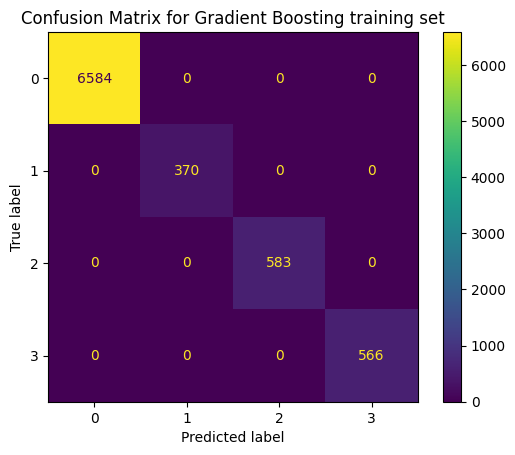

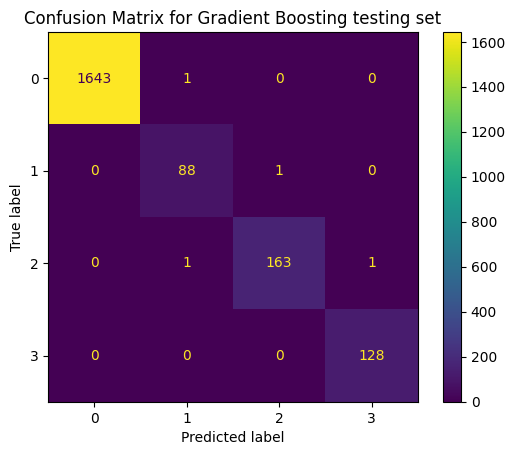

Classification report for Gradient Boosting training set:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      6584
           1       1.00      1.00      1.00       370
           2       1.00      1.00      1.00       583
           3       1.00      1.00      1.00       566

    accuracy                           1.00      8103
   macro avg       1.00      1.00      1.00      8103
weighted avg       1.00      1.00      1.00      8103

Classification report for Gradient Boosting testing set:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1644
           1       0.98      0.99      0.98        89
           2       0.99      0.99      0.99       165
           3       0.99      1.00      1.00       128

    accuracy                           1.00      2026
   macro avg       0.99      0.99      0.99      2026
weighted avg       1.00      1.00      1.00      2026

Accuracy Scor

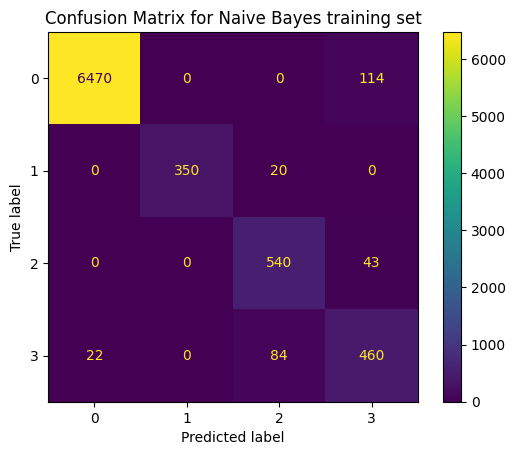

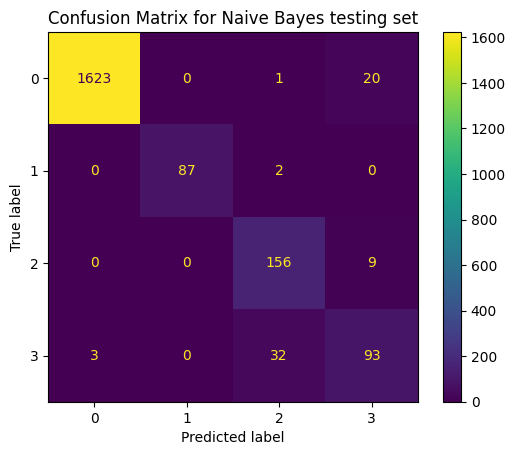

Classification report for Naive Bayes training set:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99      6584
           1       1.00      0.95      0.97       370
           2       0.84      0.93      0.88       583
           3       0.75      0.81      0.78       566

    accuracy                           0.97      8103
   macro avg       0.90      0.92      0.90      8103
weighted avg       0.97      0.97      0.97      8103

Classification report for Naive Bayes testing set:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99      1644
           1       1.00      0.98      0.99        89
           2       0.82      0.95      0.88       165
           3       0.76      0.73      0.74       128

    accuracy                           0.97      2026
   macro avg       0.89      0.91      0.90      2026
weighted avg       0.97      0.97      0.97      2026

Accuracy Score for Naive 

In [128]:
res = [] # list to store results
looker = 0 # if 0, use normal scaled data; otherwise use pca data
model_building(x_train_scaled, y_train, x_test_scaled, y_test, y_train_encoded, y_test_encoded, models = models, res = res, dim = 16)

In [129]:
og_mse_ann = mse_ann # save for later
for i in og_mse_ann:
    print(i)

0.016950535
0.0006994384
5.7256715e-09
0.0006065692
0.00088456355
4.9272186e-10
1.5491853e-09
3.7896805e-10
4.1533077e-10
0.00087155204


## PCA Results

Epoch 1/50


254/254 [==============================] - 1s 1ms/step - loss: 0.6625
Epoch 2/50
254/254 [==============================] - 0s 1ms/step - loss: 0.4380
Epoch 3/50
254/254 [==============================] - 0s 1ms/step - loss: 0.3028
Epoch 4/50
254/254 [==============================] - 0s 1ms/step - loss: 0.2700
Epoch 5/50
254/254 [==============================] - 0s 1ms/step - loss: 0.2561
Epoch 6/50
254/254 [==============================] - 0s 1ms/step - loss: 0.2480
Epoch 7/50
254/254 [==============================] - 0s 1ms/step - loss: 0.2423
Epoch 8/50
254/254 [==============================] - 0s 1ms/step - loss: 0.2385
Epoch 9/50
254/254 [==============================] - 0s 1ms/step - loss: 0.2349
Epoch 10/50
254/254 [==============================] - 0s 1ms/step - loss: 0.2329
Epoch 11/50
254/254 [==============================] - 0s 1ms/step - loss: 0.2303
Epoch 12/50
254/254 [==============================] - 0s 1ms/step - loss: 0.2279
Epoch 13/50
254/254 [===============

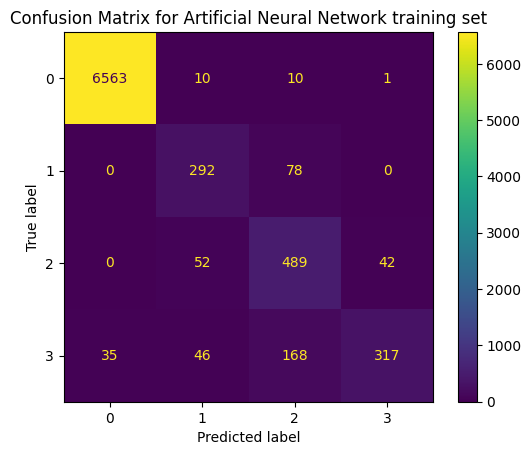

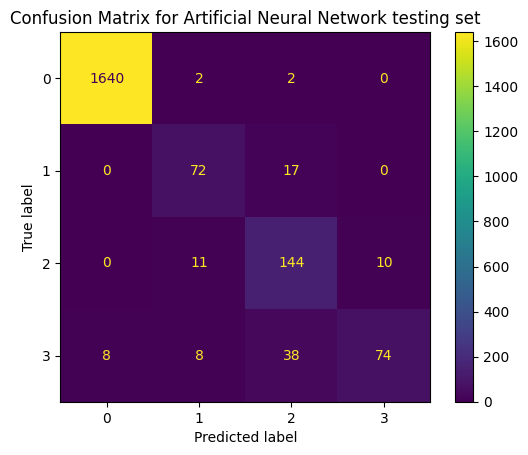

Classification report for Artificial Neural Network training set:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00      6584
           1       0.73      0.79      0.76       370
           2       0.66      0.84      0.74       583
           3       0.88      0.56      0.68       566

    accuracy                           0.95      8103
   macro avg       0.82      0.80      0.79      8103
weighted avg       0.95      0.95      0.94      8103

Classification report for Artificial Neural Network testing set:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1644
           1       0.77      0.81      0.79        89
           2       0.72      0.87      0.79       165
           3       0.88      0.58      0.70       128

    accuracy                           0.95      2026
   macro avg       0.84      0.81      0.82      2026
weighted avg       0.96      0.95      0.95      202

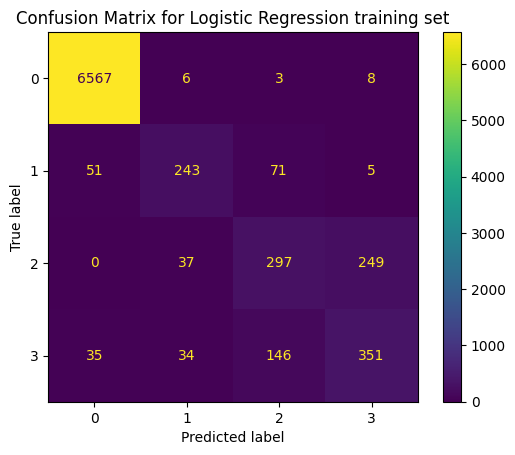

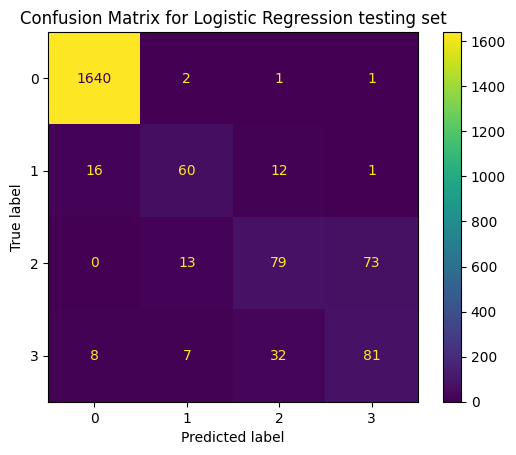

Classification report for Logistic Regression training set:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99      6584
           1       0.76      0.66      0.70       370
           2       0.57      0.51      0.54       583
           3       0.57      0.62      0.60       566

    accuracy                           0.92      8103
   macro avg       0.72      0.70      0.71      8103
weighted avg       0.92      0.92      0.92      8103

Classification report for Logistic Regression testing set:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99      1644
           1       0.73      0.67      0.70        89
           2       0.64      0.48      0.55       165
           3       0.52      0.63      0.57       128

    accuracy                           0.92      2026
   macro avg       0.72      0.70      0.70      2026
weighted avg       0.92      0.92      0.92      2026

Accuracy 

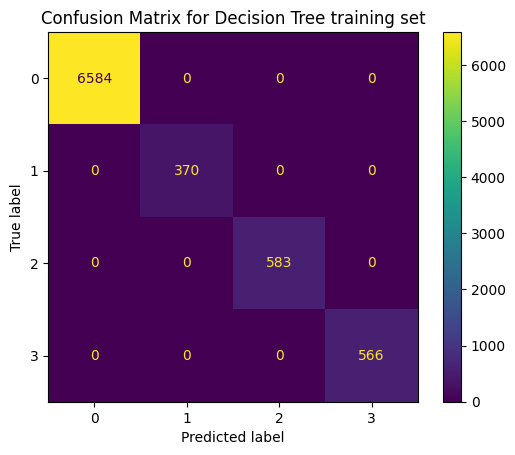

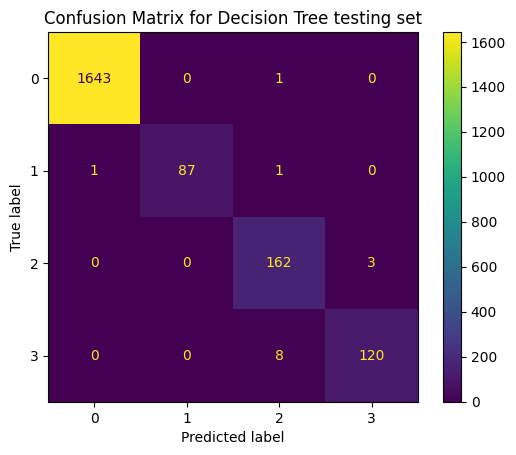

Classification report for Decision Tree training set:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      6584
           1       1.00      1.00      1.00       370
           2       1.00      1.00      1.00       583
           3       1.00      1.00      1.00       566

    accuracy                           1.00      8103
   macro avg       1.00      1.00      1.00      8103
weighted avg       1.00      1.00      1.00      8103

Classification report for Decision Tree testing set:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1644
           1       1.00      0.98      0.99        89
           2       0.94      0.98      0.96       165
           3       0.98      0.94      0.96       128

    accuracy                           0.99      2026
   macro avg       0.98      0.97      0.98      2026
weighted avg       0.99      0.99      0.99      2026

Accuracy Score for De

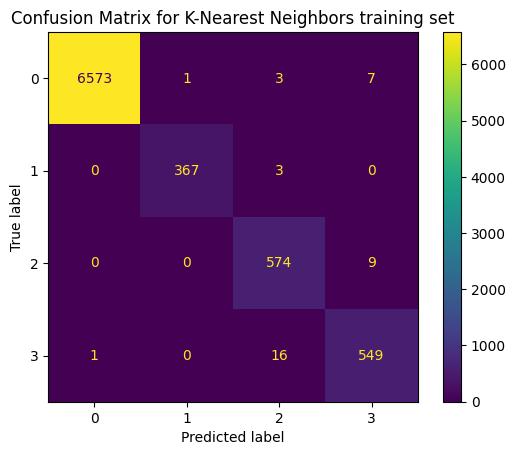

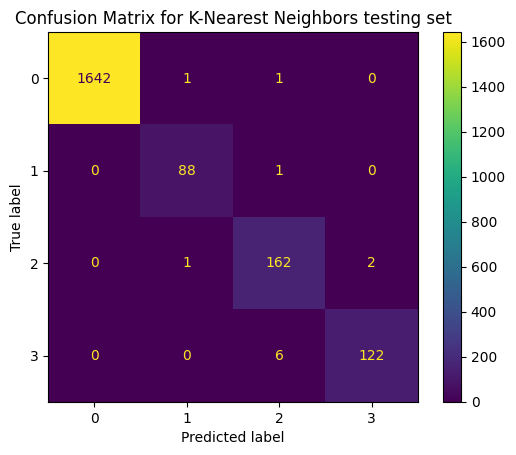

Classification report for K-Nearest Neighbors training set:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      6584
           1       1.00      0.99      0.99       370
           2       0.96      0.98      0.97       583
           3       0.97      0.97      0.97       566

    accuracy                           1.00      8103
   macro avg       0.98      0.99      0.98      8103
weighted avg       1.00      1.00      1.00      8103

Classification report for K-Nearest Neighbors testing set:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1644
           1       0.98      0.99      0.98        89
           2       0.95      0.98      0.97       165
           3       0.98      0.95      0.97       128

    accuracy                           0.99      2026
   macro avg       0.98      0.98      0.98      2026
weighted avg       0.99      0.99      0.99      2026

Accuracy 

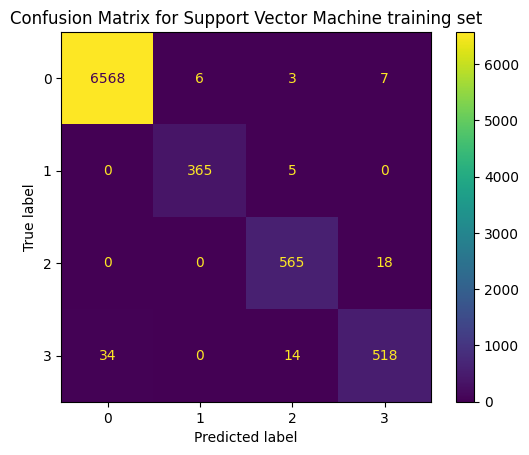

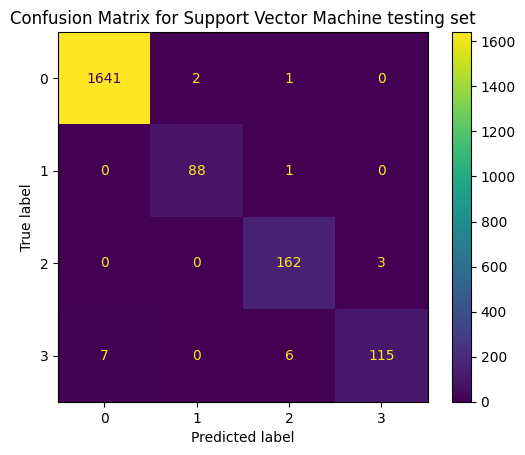

Classification report for Support Vector Machine training set:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00      6584
           1       0.98      0.99      0.99       370
           2       0.96      0.97      0.97       583
           3       0.95      0.92      0.93       566

    accuracy                           0.99      8103
   macro avg       0.97      0.97      0.97      8103
weighted avg       0.99      0.99      0.99      8103

Classification report for Support Vector Machine testing set:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1644
           1       0.98      0.99      0.98        89
           2       0.95      0.98      0.97       165
           3       0.97      0.90      0.93       128

    accuracy                           0.99      2026
   macro avg       0.98      0.97      0.97      2026
weighted avg       0.99      0.99      0.99      2026

Acc

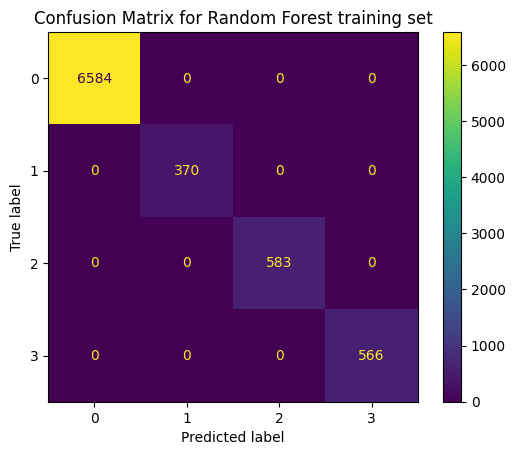

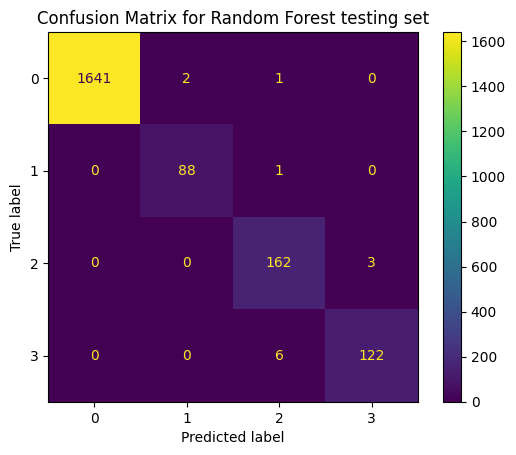

Classification report for Random Forest training set:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      6584
           1       1.00      1.00      1.00       370
           2       1.00      1.00      1.00       583
           3       1.00      1.00      1.00       566

    accuracy                           1.00      8103
   macro avg       1.00      1.00      1.00      8103
weighted avg       1.00      1.00      1.00      8103

Classification report for Random Forest testing set:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1644
           1       0.98      0.99      0.98        89
           2       0.95      0.98      0.97       165
           3       0.98      0.95      0.96       128

    accuracy                           0.99      2026
   macro avg       0.98      0.98      0.98      2026
weighted avg       0.99      0.99      0.99      2026

Accuracy Score for Ra

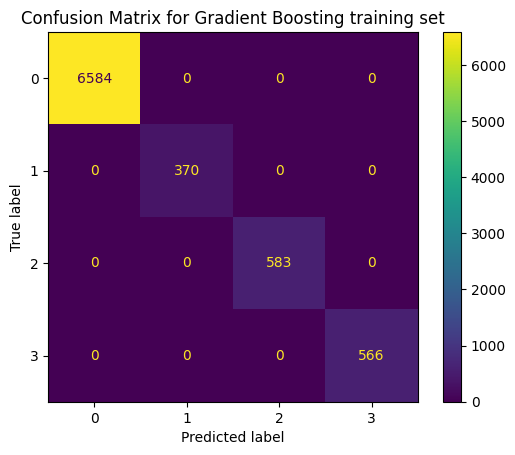

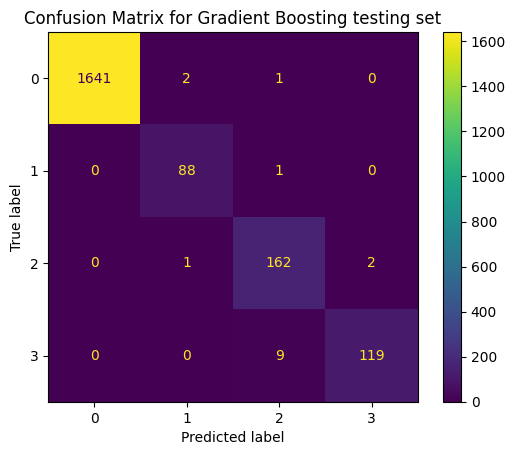

Classification report for Gradient Boosting training set:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      6584
           1       1.00      1.00      1.00       370
           2       1.00      1.00      1.00       583
           3       1.00      1.00      1.00       566

    accuracy                           1.00      8103
   macro avg       1.00      1.00      1.00      8103
weighted avg       1.00      1.00      1.00      8103

Classification report for Gradient Boosting testing set:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1644
           1       0.97      0.99      0.98        89
           2       0.94      0.98      0.96       165
           3       0.98      0.93      0.96       128

    accuracy                           0.99      2026
   macro avg       0.97      0.97      0.97      2026
weighted avg       0.99      0.99      0.99      2026

Accuracy Scor

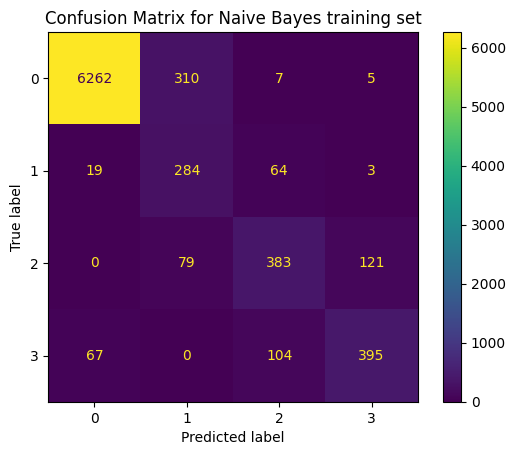

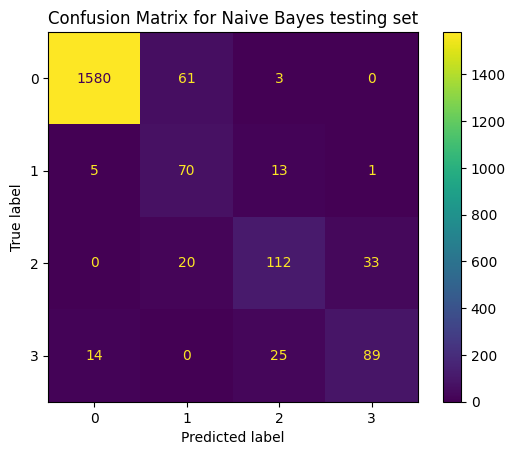

Classification report for Naive Bayes training set:
               precision    recall  f1-score   support

           0       0.99      0.95      0.97      6584
           1       0.42      0.77      0.54       370
           2       0.69      0.66      0.67       583
           3       0.75      0.70      0.72       566

    accuracy                           0.90      8103
   macro avg       0.71      0.77      0.73      8103
weighted avg       0.92      0.90      0.91      8103

Classification report for Naive Bayes testing set:
               precision    recall  f1-score   support

           0       0.99      0.96      0.97      1644
           1       0.46      0.79      0.58        89
           2       0.73      0.68      0.70       165
           3       0.72      0.70      0.71       128

    accuracy                           0.91      2026
   macro avg       0.73      0.78      0.74      2026
weighted avg       0.93      0.91      0.92      2026

Accuracy Score for Naive 

In [130]:

models2 = {'Artificial Neural Network': Sequential(),
'Logistic Regression': LogisticRegression(),
'Decision Tree': DecisionTreeClassifier(),
'K-Nearest Neighbors': KNeighborsClassifier(),
'Support Vector Machine': SVC(),
'Random Forest': RandomForestClassifier(),
'Gradient Boosting': XGBClassifier(),
'Naive Bayes': GaussianNB()} # dictionary of models to iterate data through

mse_ann = []
res_pca = []
model_building(reduced_x_train, y_train, reduced_x_test, y_test, y_train_encoded, y_test_encoded, models = models2, res = res_pca, dim = 3)
pca_mse_ann = mse_ann

In [131]:
for i in pca_mse_ann:
    print(i)

0.07172747
0.0011988231
1.64069e-06
0.0050208624
0.004531152
1.9832818e-08
0.0011150046
0.002300614
0.00059066946
0.010824651


# Random Oversampling

Epoch 1/50
823/823 [==============================] - 1s 1ms/step - loss: 1.0512
Epoch 2/50
823/823 [==============================] - 1s 1ms/step - loss: 0.5281
Epoch 3/50
823/823 [==============================] - 1s 1ms/step - loss: 0.2144
Epoch 4/50
823/823 [==============================] - 1s 1ms/step - loss: 0.1204
Epoch 5/50
823/823 [==============================] - 1s 1ms/step - loss: 0.1006
Epoch 6/50
823/823 [==============================] - 1s 1ms/step - loss: 0.0877
Epoch 7/50
823/823 [==============================] - 1s 1ms/step - loss: 0.0776
Epoch 8/50
823/823 [==============================] - 1s 1ms/step - loss: 0.0701
Epoch 9/50
823/823 [==============================] - 1s 1ms/step - loss: 0.0658
Epoch 10/50
823/823 [==============================] - 1s 1ms/step - loss: 0.0627
Epoch 11/50
823/823 [==============================] - 1s 1ms/step - loss: 0.0602
Epoch 12/50
823/823 [==============================] - 1s 1ms/step - loss: 0.0584
Epoch 13/50
823/823 [====

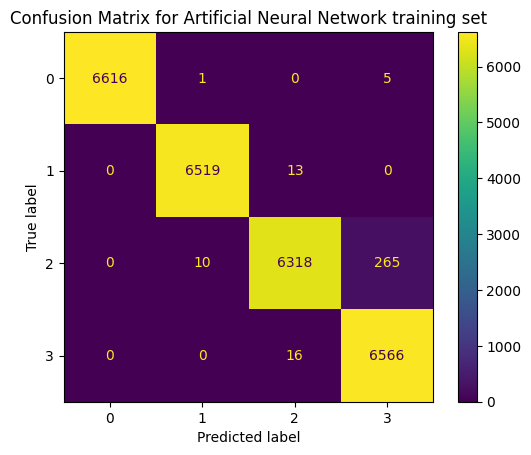

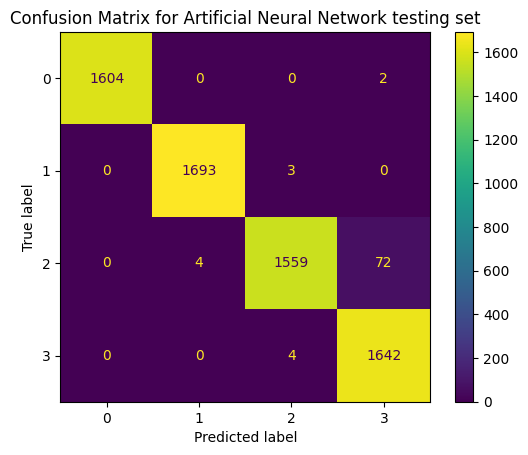

Classification report for Artificial Neural Network training set:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      6622
           1       1.00      1.00      1.00      6532
           2       1.00      0.96      0.98      6593
           3       0.96      1.00      0.98      6582

    accuracy                           0.99     26329
   macro avg       0.99      0.99      0.99     26329
weighted avg       0.99      0.99      0.99     26329

Classification report for Artificial Neural Network testing set:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1606
           1       1.00      1.00      1.00      1696
           2       1.00      0.95      0.97      1635
           3       0.96      1.00      0.98      1646

    accuracy                           0.99      6583
   macro avg       0.99      0.99      0.99      6583
weighted avg       0.99      0.99      0.99      658

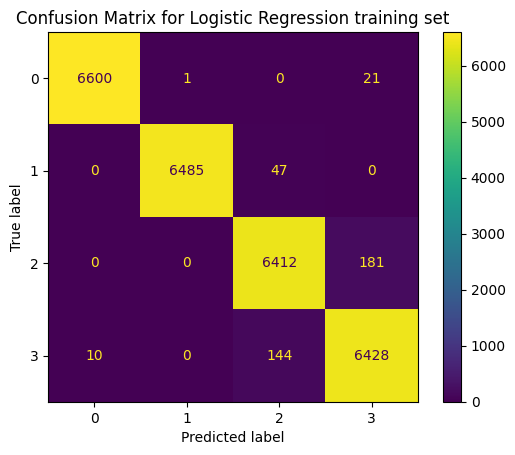

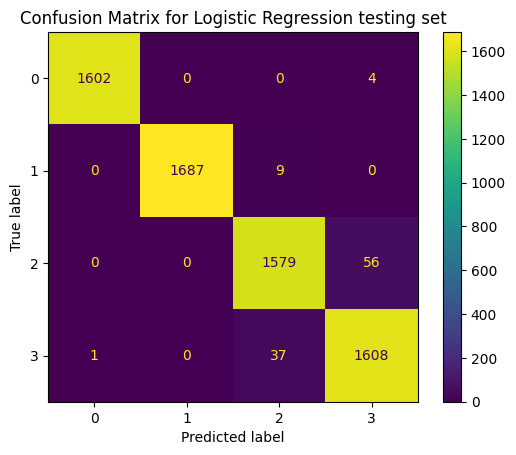

Classification report for Logistic Regression training set:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      6622
           1       1.00      0.99      1.00      6532
           2       0.97      0.97      0.97      6593
           3       0.97      0.98      0.97      6582

    accuracy                           0.98     26329
   macro avg       0.98      0.98      0.98     26329
weighted avg       0.98      0.98      0.98     26329

Classification report for Logistic Regression testing set:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1606
           1       1.00      0.99      1.00      1696
           2       0.97      0.97      0.97      1635
           3       0.96      0.98      0.97      1646

    accuracy                           0.98      6583
   macro avg       0.98      0.98      0.98      6583
weighted avg       0.98      0.98      0.98      6583

Accuracy 

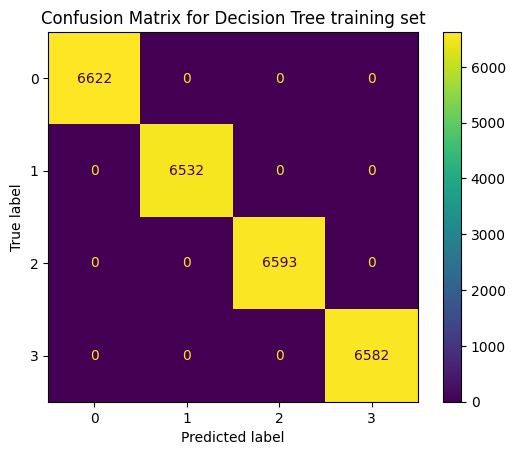

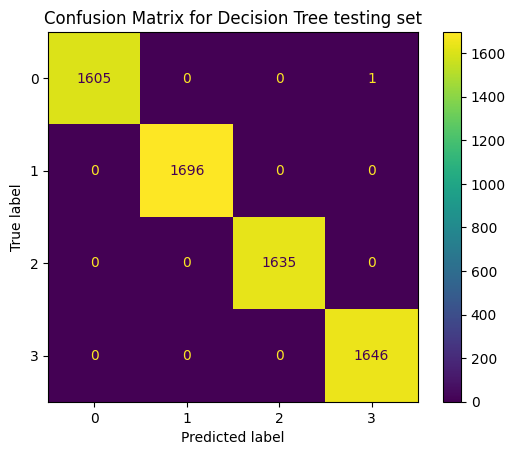

Classification report for Decision Tree training set:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      6622
           1       1.00      1.00      1.00      6532
           2       1.00      1.00      1.00      6593
           3       1.00      1.00      1.00      6582

    accuracy                           1.00     26329
   macro avg       1.00      1.00      1.00     26329
weighted avg       1.00      1.00      1.00     26329

Classification report for Decision Tree testing set:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1606
           1       1.00      1.00      1.00      1696
           2       1.00      1.00      1.00      1635
           3       1.00      1.00      1.00      1646

    accuracy                           1.00      6583
   macro avg       1.00      1.00      1.00      6583
weighted avg       1.00      1.00      1.00      6583

Accuracy Score for De

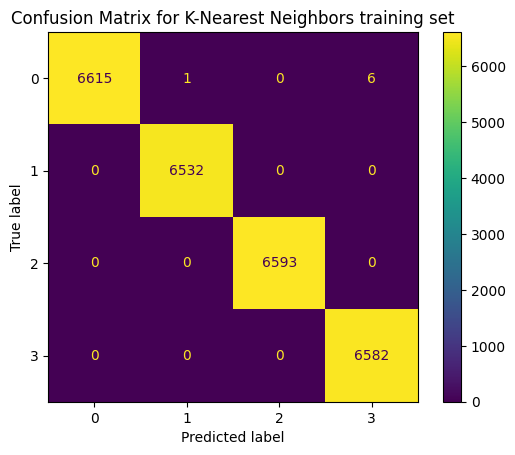

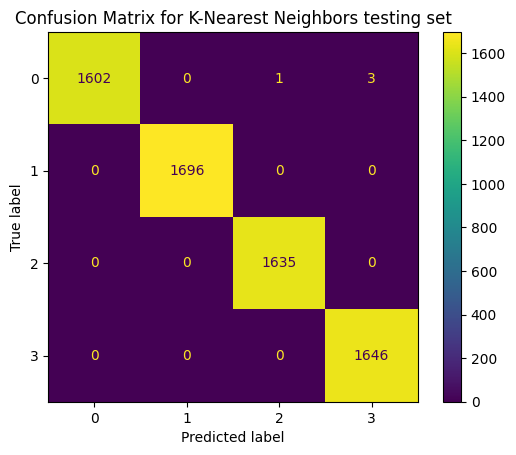

Classification report for K-Nearest Neighbors training set:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      6622
           1       1.00      1.00      1.00      6532
           2       1.00      1.00      1.00      6593
           3       1.00      1.00      1.00      6582

    accuracy                           1.00     26329
   macro avg       1.00      1.00      1.00     26329
weighted avg       1.00      1.00      1.00     26329

Classification report for K-Nearest Neighbors testing set:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1606
           1       1.00      1.00      1.00      1696
           2       1.00      1.00      1.00      1635
           3       1.00      1.00      1.00      1646

    accuracy                           1.00      6583
   macro avg       1.00      1.00      1.00      6583
weighted avg       1.00      1.00      1.00      6583

Accuracy 

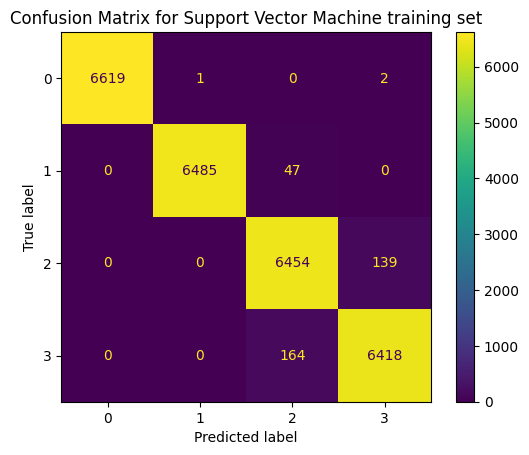

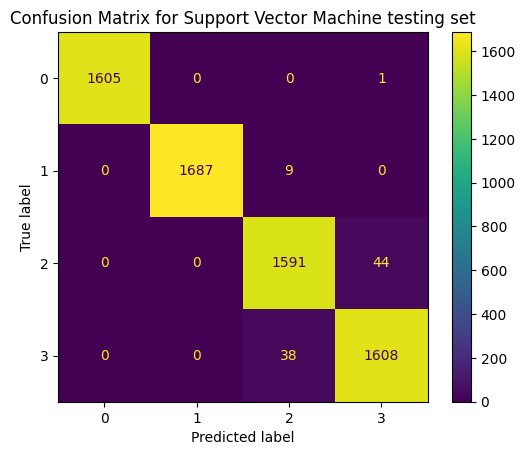

Classification report for Support Vector Machine training set:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      6622
           1       1.00      0.99      1.00      6532
           2       0.97      0.98      0.97      6593
           3       0.98      0.98      0.98      6582

    accuracy                           0.99     26329
   macro avg       0.99      0.99      0.99     26329
weighted avg       0.99      0.99      0.99     26329

Classification report for Support Vector Machine testing set:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1606
           1       1.00      0.99      1.00      1696
           2       0.97      0.97      0.97      1635
           3       0.97      0.98      0.97      1646

    accuracy                           0.99      6583
   macro avg       0.99      0.99      0.99      6583
weighted avg       0.99      0.99      0.99      6583

Acc

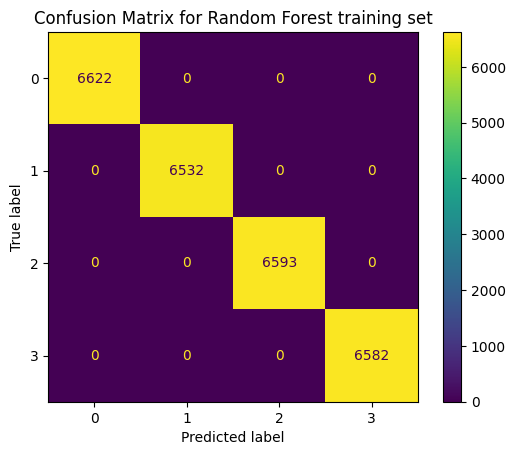

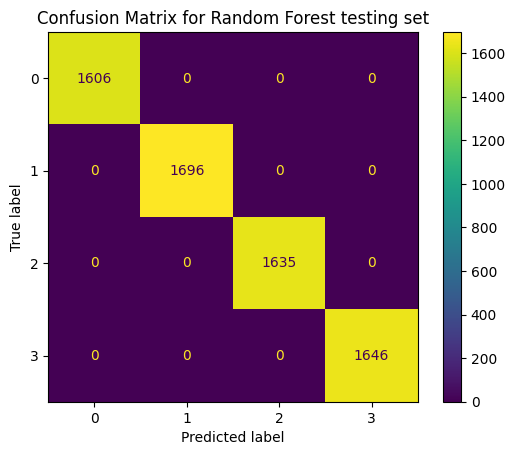

Classification report for Random Forest training set:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      6622
           1       1.00      1.00      1.00      6532
           2       1.00      1.00      1.00      6593
           3       1.00      1.00      1.00      6582

    accuracy                           1.00     26329
   macro avg       1.00      1.00      1.00     26329
weighted avg       1.00      1.00      1.00     26329

Classification report for Random Forest testing set:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1606
           1       1.00      1.00      1.00      1696
           2       1.00      1.00      1.00      1635
           3       1.00      1.00      1.00      1646

    accuracy                           1.00      6583
   macro avg       1.00      1.00      1.00      6583
weighted avg       1.00      1.00      1.00      6583

Accuracy Score for Ra

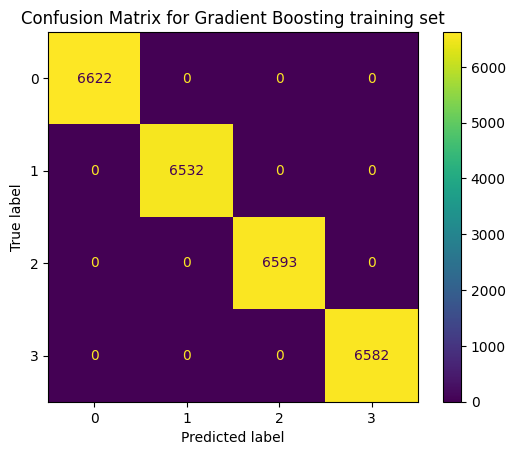

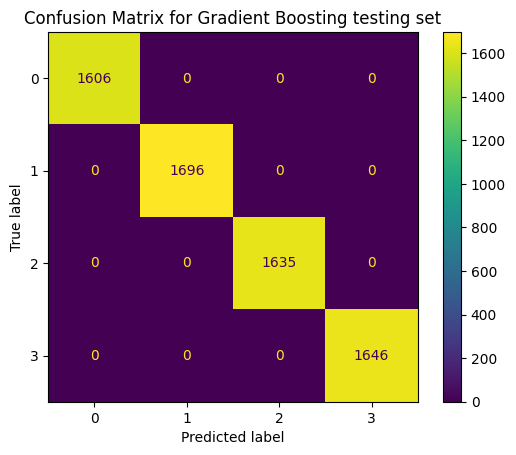

Classification report for Gradient Boosting training set:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      6622
           1       1.00      1.00      1.00      6532
           2       1.00      1.00      1.00      6593
           3       1.00      1.00      1.00      6582

    accuracy                           1.00     26329
   macro avg       1.00      1.00      1.00     26329
weighted avg       1.00      1.00      1.00     26329

Classification report for Gradient Boosting testing set:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1606
           1       1.00      1.00      1.00      1696
           2       1.00      1.00      1.00      1635
           3       1.00      1.00      1.00      1646

    accuracy                           1.00      6583
   macro avg       1.00      1.00      1.00      6583
weighted avg       1.00      1.00      1.00      6583

Accuracy Scor

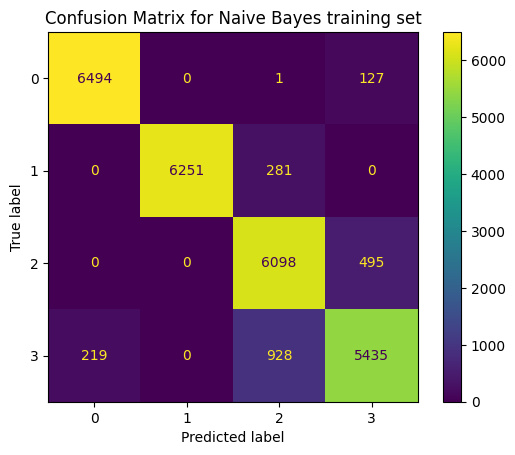

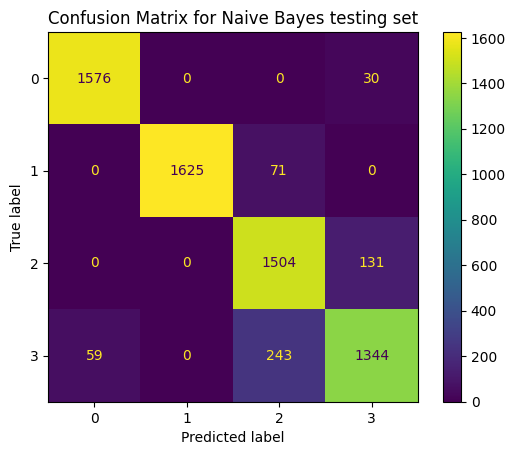

Classification report for Naive Bayes training set:
               precision    recall  f1-score   support

           0       0.97      0.98      0.97      6622
           1       1.00      0.96      0.98      6532
           2       0.83      0.92      0.88      6593
           3       0.90      0.83      0.86      6582

    accuracy                           0.92     26329
   macro avg       0.92      0.92      0.92     26329
weighted avg       0.92      0.92      0.92     26329

Classification report for Naive Bayes testing set:
               precision    recall  f1-score   support

           0       0.96      0.98      0.97      1606
           1       1.00      0.96      0.98      1696
           2       0.83      0.92      0.87      1635
           3       0.89      0.82      0.85      1646

    accuracy                           0.92      6583
   macro avg       0.92      0.92      0.92      6583
weighted avg       0.92      0.92      0.92      6583

Accuracy Score for Naive 

In [132]:

X_os = df.iloc[:, :-1] # get all columns except room_occupancy
y_os = df.iloc[:,-1] # room occupancy

ros = RandomOverSampler(random_state=9)
X_resampled, y_resampled = ros.fit_resample(X_os,y_os)

x_train_os, x_test_os, y_train_os, y_test_os = train_test_split(X_resampled, y_resampled, test_size = 0.2, random_state = 2)

y_train_encoded_os = tf.keras.utils.to_categorical(y_train_os, num_classes = 4) # convert to categorical data for later analysis
y_test_encoded_os = tf.keras.utils.to_categorical(y_test_os, num_classes = 4) # convert to categorical data for later analysis
y_encoded_os = tf.keras.utils.to_categorical(y_os, num_classes=4)

x_train_scaled_os = scaler.fit_transform(x_train_os)
x_test_scaled_os = scaler.transform(x_test_os)
X_scaled_os = scaler.fit_transform(X_os)

models3 = {'Artificial Neural Network': Sequential(),
'Logistic Regression': LogisticRegression(),
'Decision Tree': DecisionTreeClassifier(),
'K-Nearest Neighbors': KNeighborsClassifier(),
'Support Vector Machine': SVC(),
'Random Forest': RandomForestClassifier(),
'Gradient Boosting': XGBClassifier(),
'Naive Bayes': GaussianNB()} # dictionary of models to iterate data through
res3 = [] # list to store results
mse_ann = []

model_building(x_train_scaled_os, y_train_os, x_test_scaled_os, y_test_os, y_train_encoded_os, y_test_encoded_os, models = models3, res = res3, dim = 16, os = True, cross_val = False) # cross validation is set to false as it will not work otherwise
#os_mse_ann = mse_ann

In [133]:
#for i in os_mse_ann: # print mse from kfold cross validation
    #print(i)

# Cross Validation (not for ANN)

In [134]:
def cross_validate(models:dict, X, y, cv = 10):
    """Do cross validation for all models except ANN (is done earlier in the model_building function)"""
    res_dict = {}
    for name, model in models.items():
        if name == 'Artificial Neural Network': # i'll do this later with hyperparameter gridsearch
            continue
        score = cross_val_score(model, X,y, cv = cv, scoring = 'accuracy') # cross validate models 
        res_dict[name] = {'Score': score, 'Average Score': np.mean(score), 'Standard Deviation': np.std(score)}

    return res_dict



In [142]:
cross_validate(models, X_scaled_og, y)

{'Logistic Regression': {'Score': array([0.94274432, 0.97433366, 0.99506417, 1.        , 0.99901283,
         1.        , 1.        , 0.96347483, 0.95557749, 0.92786561]),
  'Average Score': 0.9758072917682771,
  'Standard Deviation': 0.02572985859509991},
 'Decision Tree': {'Score': array([0.88450148, 0.96643633, 0.97235933, 0.99802567, 0.97235933,
         0.97532083, 0.98124383, 0.94471866, 0.988154  , 0.96640316]),
  'Average Score': 0.9649522609241912,
  'Standard Deviation': 0.030001427972121346},
 'K-Nearest Neighbors': {'Score': array([0.94471866, 0.976308  , 0.988154  , 0.99901283, 0.994077  ,
         0.94076999, 1.        , 0.9970385 , 0.99308983, 0.96245059]),
  'Average Score': 0.9795619398413509,
  'Standard Deviation': 0.021427207015232746},
 'Support Vector Machine': {'Score': array([0.95064166, 0.97532083, 0.98716683, 0.99901283, 0.99901283,
         0.99901283, 1.        , 0.9970385 , 0.99901283, 0.98221344]),
  'Average Score': 0.9888432589771702,
  'Standard Deviati

In [143]:
cross_validate(models2, reduced_x, y)

{'Logistic Regression': {'Score': array([0.82527147, 0.92694965, 0.92793682, 0.92892399, 0.93978282,
         0.9733465 , 0.93287266, 0.85389931, 0.86475814, 0.84881423]),
  'Average Score': 0.902255559153924,
  'Standard Deviation': 0.04680498126331341},
 'Decision Tree': {'Score': array([0.78973346, 0.96248766, 0.92694965, 0.99506417, 0.98025666,
         0.75715696, 0.9911155 , 0.96544916, 0.98914116, 0.95849802]),
  'Average Score': 0.9315852416607815,
  'Standard Deviation': 0.08163925530322745},
 'K-Nearest Neighbors': {'Score': array([0.92300099, 0.97729516, 0.9851925 , 0.99802567, 0.994077  ,
         0.8183613 , 1.        , 0.9851925 , 0.98420533, 0.96936759]),
  'Average Score': 0.9634718033157881,
  'Standard Deviation': 0.05268700283810799},
 'Support Vector Machine': {'Score': array([0.92694965, 0.976308  , 0.99012833, 1.        , 0.99605133,
         0.89733465, 1.        , 0.982231  , 0.9733465 , 0.97332016]),
  'Average Score': 0.971566961516101,
  'Standard Deviation':

In [144]:
cross_validate(models3, X_scaled_os,y)

{'Logistic Regression': {'Score': array([0.94274432, 0.97433366, 0.99506417, 1.        , 0.99901283,
         1.        , 1.        , 0.96347483, 0.95557749, 0.92786561]),
  'Average Score': 0.9758072917682771,
  'Standard Deviation': 0.02572985859509991},
 'Decision Tree': {'Score': array([0.86771964, 0.96544916, 0.95360316, 0.99605133, 0.97828233,
         0.97828233, 0.98124383, 0.94471866, 0.98914116, 0.96640316]),
  'Average Score': 0.9620894771137272,
  'Standard Deviation': 0.03476468214413417},
 'K-Nearest Neighbors': {'Score': array([0.94471866, 0.976308  , 0.988154  , 0.99901283, 0.994077  ,
         0.94076999, 1.        , 0.9970385 , 0.99308983, 0.96245059]),
  'Average Score': 0.9795619398413509,
  'Standard Deviation': 0.021427207015232746},
 'Support Vector Machine': {'Score': array([0.95064166, 0.97532083, 0.98716683, 0.99901283, 0.99901283,
         0.99901283, 1.        , 0.9970385 , 0.99901283, 0.98221344]),
  'Average Score': 0.9888432589771702,
  'Standard Deviatio

# Plotting Model Results

In [145]:
# extract results from list
acc_train1 = []
acc_test1 = [] 
mse_train1 = []
mse_test1 = []

acc_train_pca = []
acc_test_pca = [] 
mse_train_pca = []
mse_test_pca = []

acc_train_os = []
acc_test_os = [] 
mse_train_os = []
mse_test_os = []

for i in res:
    # extract accuracy and mse for each model so it can be plotted
    acc_train1.append(i[4])
    acc_test1.append(i[5])
    mse_train1.append(i[6])
    mse_test1.append(i[7])

for i in res_pca:
    # extract accuracy and mse for each model so it can be plotted
    acc_train_pca.append(i[4])
    acc_test_pca.append(i[5])
    mse_train_pca.append(i[6])
    mse_test_pca.append(i[7])

for i in res3:
    # extract accuracy and mse for each model so it can be plotted
    acc_train_os.append(i[4])
    acc_test_os.append(i[5])
    mse_train_os.append(i[6])
    mse_test_os.append(i[7])


In [146]:
def make_plots(train,test,title, y_label):
    """Function that makes plots for a given metric given the correct info for the 
    train and test values."""
    plt.figure(figsize = (10,8))
    plt.plot(range(len(models)), train, marker='o', label='Train') # plot results from using train data
    plt.plot(range(len(models)), test, marker='o', label='Test') # plot results from test data
    plt.xticks(range(len(models)), models.keys(), rotation=45) # take names from models dictionary as xticks
    plt.xlabel('Model Type')
    plt.ylabel(y_label)
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()


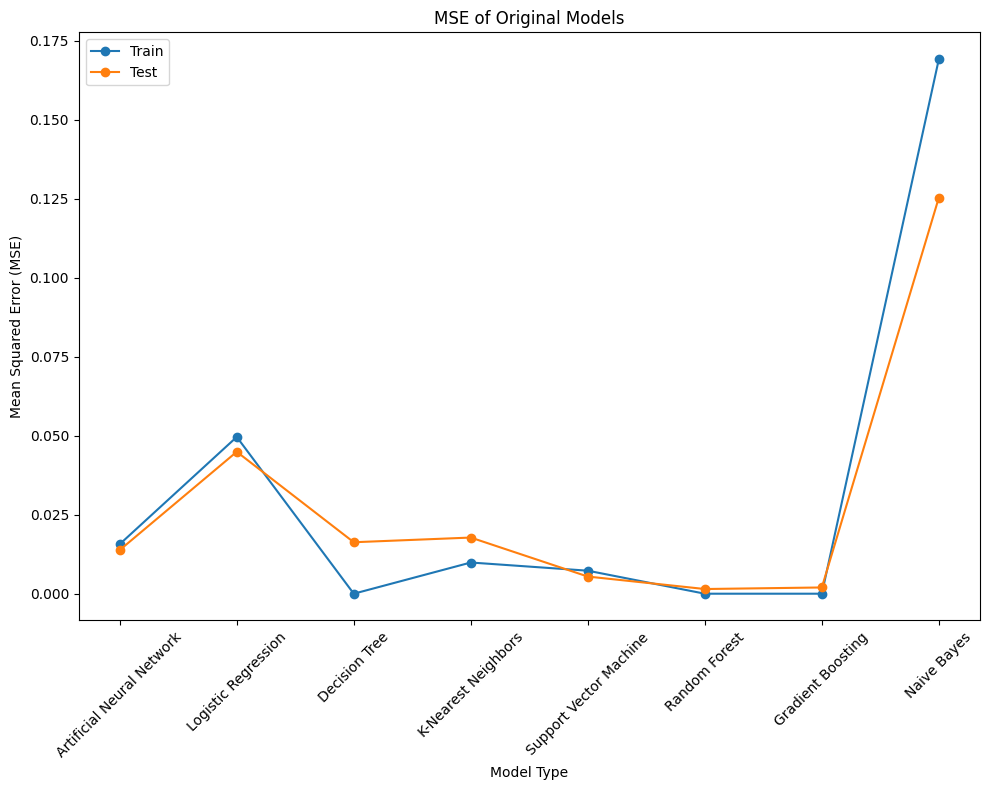

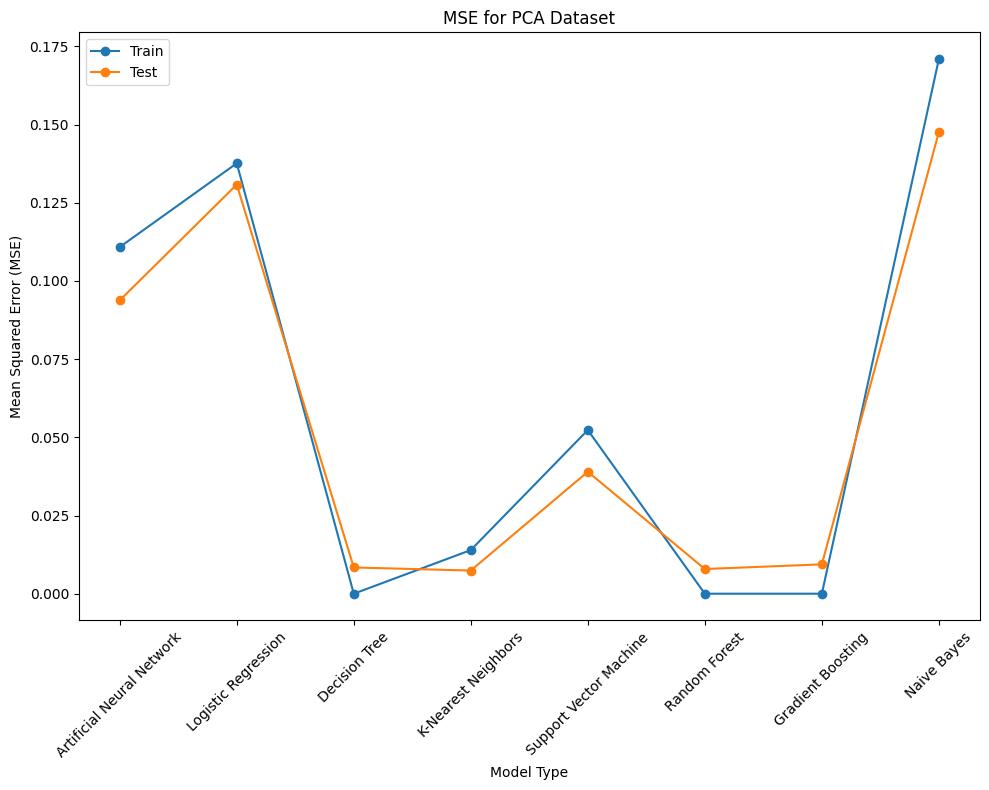

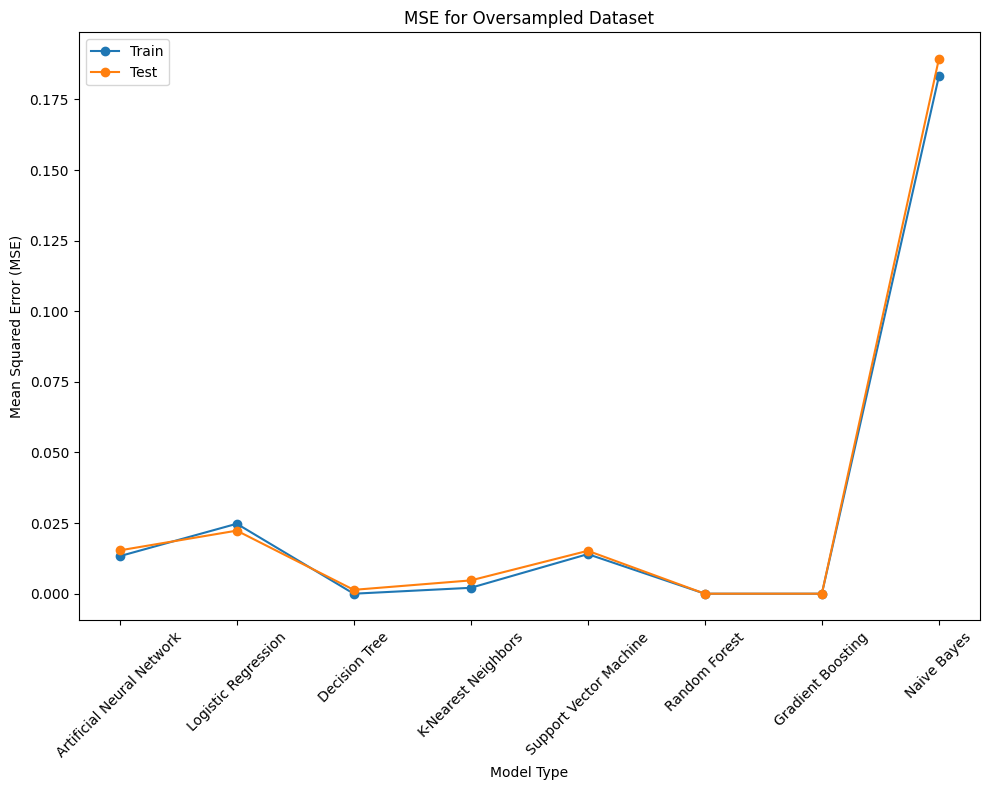

In [147]:
make_plots(mse_train1,mse_test1,'MSE of Original Models', 'Mean Squared Error (MSE)')
make_plots(mse_train_pca, mse_test_pca, 'MSE for PCA Dataset', 'Mean Squared Error (MSE)')
make_plots(mse_train_os, mse_test_os, 'MSE for Oversampled Dataset', 'Mean Squared Error (MSE)')

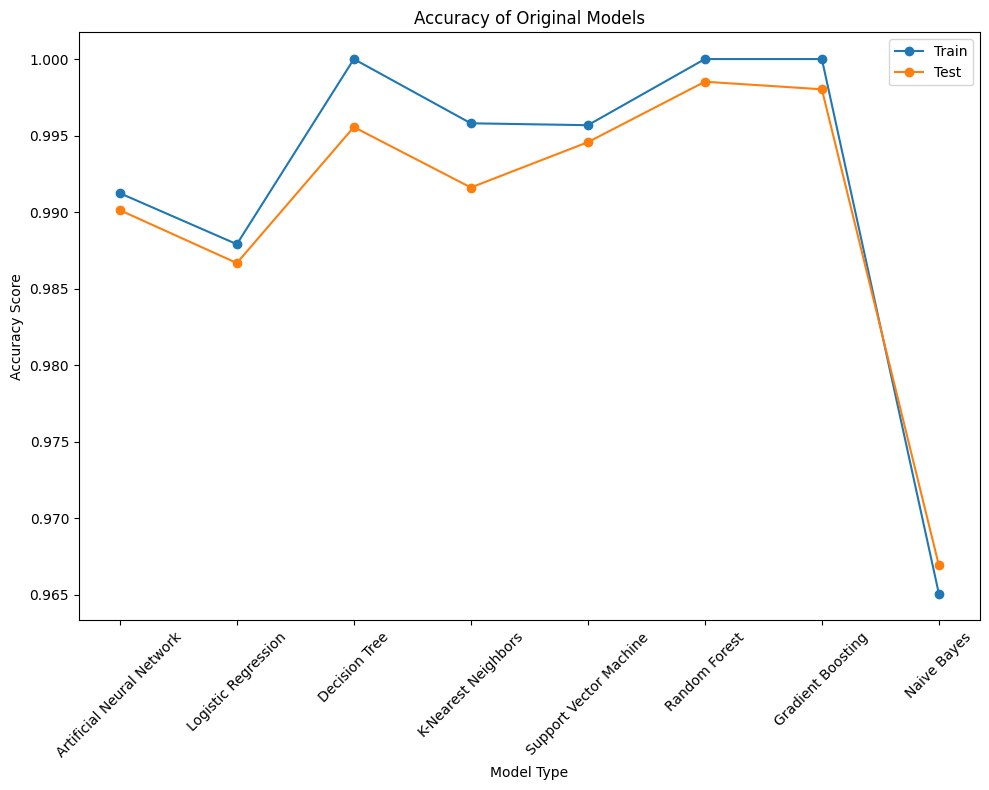

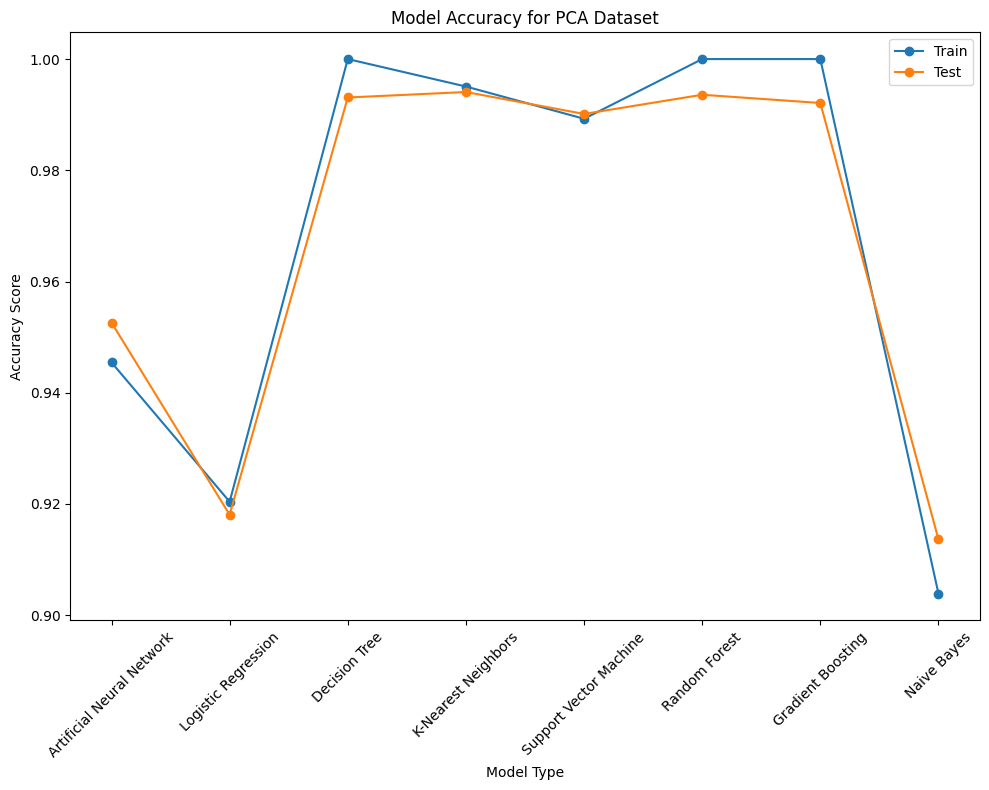

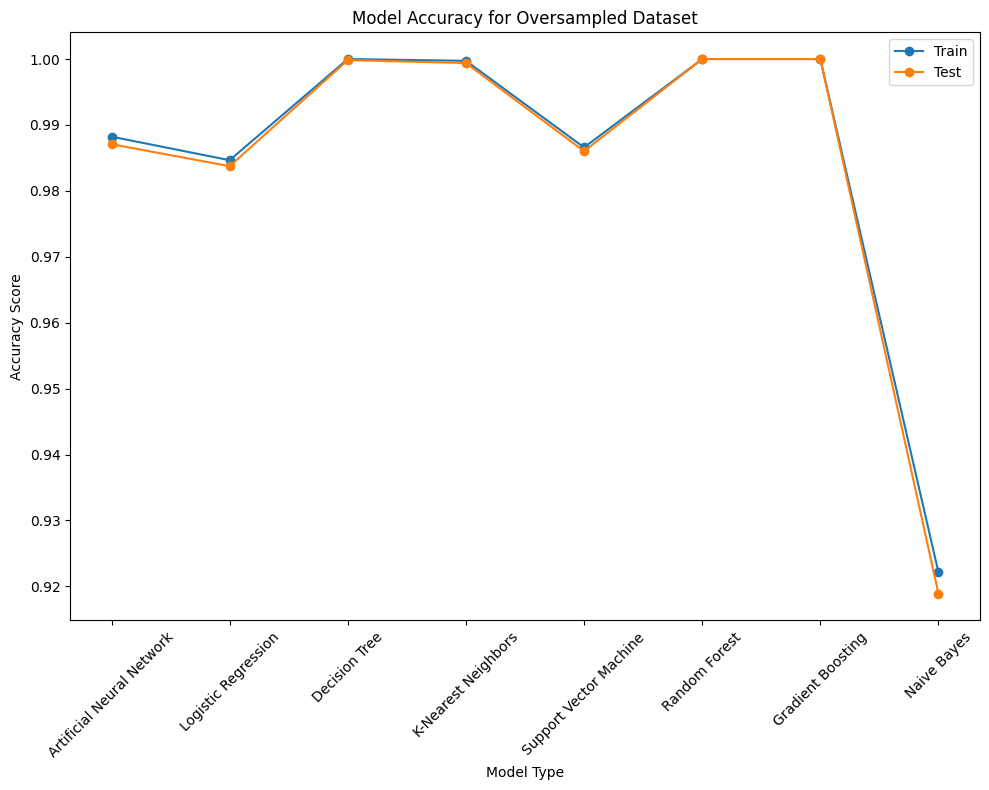

In [148]:
make_plots(acc_train1, acc_test1, 'Accuracy of Original Models', 'Accuracy Score')
make_plots(acc_train_pca, acc_test_pca, 'Model Accuracy for PCA Dataset', 'Accuracy Score')
make_plots(acc_train_os, acc_test_os, 'Model Accuracy for Oversampled Dataset', 'Accuracy Score')